In [1]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2TkAgg
from matplotlib import colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
import numpy as np
np.set_printoptions(threshold='nan')
import pandas as pd
import seaborn as sns
sns.set_style('white')
import sys
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
from astropy.io import fits
    
#from tkFileDialog import askopenfilename,askdirectory,asksaveasfile
sys.path.append('python')
import clusterOutliers
import keplerml
%matplotlib inline


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [ ]:
def make_sample(inds=['8462852']): return lambda df: df[df.index.str.contains('|'.join(inds))]
# Creates a function that can be called with with data as the only input, makes it easier to
# reuse sample lists
tabby_sample = make_sample(['8462852'])

Q4_tabby = tabby_sample(Q4.data)
Q8_tabby = tabby_sample(Q8.data)
Q4_tabby

In [61]:
def make_sampler(inds=['8462852']): 
    """
    Args:
        inds (Array of strings) - array of inds, as identifying strings, to be pulled from a data frame
    Returns:
        Function that will pull the data, indicated by inds, from a dataframe df 
        
    Useful to generate samples across quarters with common sources
    
    Use:
        Define array of string IDs with sources of interest
        Define a sample generator by calling make_sampler(inds=Array of string IDs)
        Generate dataframe by calling new function.

    Example:
    tabby_sample = make_sampler(inds=['8462852'])
    Q4_sample = tabby_sample(Q4.data)
    Q8_sample = tabby_sample(Q8.data)
    etc.
    """
    return lambda df: df[df.index.str.contains('|'.join(inds))]

def annotatePts(hl_data,ax):
    """
    Annotate an axis with labels in small rounded boxes
    Args:
        X (np.array) - array of points, of shape (numPoints, 3)
        index (int) - index (into points array X) of item which should be printed
    Returns:
        None
    """
    
    def duplicates(z):
        """
        Checks for duplicate pts in n x 2 array z
        Args:
            z (nx2 np.array) - numpy array containing n, 2D pts
        Returns:
            Numpy array with each index containing indices of duplicate pts
        """
        x = z[:,0]
        y = z[:,1]
        # sorted indexes based on x's primarily, y secondarily
        idx_sort = np.lexsort((y,x))
        z_sorted = z[idx_sort]
        # unique elements, using z_sorted so the indices are returned in order
        u,idx = np.unique(z_sorted,axis=0,return_index=True)
        # Split sorted indices along unique indices
        idx_split = np.split(idx_sort,idx[1:])
        # Only care about duplicates
        dup_inds = filter(lambda x: x.size > 1,idx_split)
        return dup_inds
    
    def label_adjust(x,y,step):
        """
        Adjusts y-value of duplicate pts to avoid overlap.
        Args:
            x (numpy array, dtype=float) - array of x values
            y (numpy array, dtype=float) - array of y values
            step (float) - size of adjustment to make to y value of duplicate pts
        """
        z = np.stack([x,y],axis=1)
        dup_inds = duplicates(z)
        # making adjustments if there are duplicates
        if dup_inds !=[]:
            i = 1 # Safety net
            while dup_inds!=[]:
                for dup in dup_inds:
                    z[dup[1:]]+=[0,step]

                dup_inds = duplicates(z)

                i+=1
                if i>100:
                    break
        x=z[:,0]
        y=z[:,1]
        return x,y
    
    x_data = hl_data.tsne_x
    y_data = hl_data.tsne_y
    cs = colors_for_plot(hl_data.db_out,cmap='color_blind')
    
    # Pyplot Scatter doesn't plot over the KDE plot for some reason, pyplot plot does
    for i in range(len(x_data)):
        ax.plot(x_data[i],y_data[i],marker='o',c=cs[i])

    x_grid = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],8)
    y_grid = np.linspace(ax.get_ylim()[0],ax.get_ylim()[1],21) # creating a grid for labels to be situated on

    
    xt = np.array([x_grid[min(np.abs(x_grid-x).argmin()+1,len(x_grid)-1)] for x in x_data])
    yt = np.array([y_grid[min(np.abs(y_grid-y).argmin()+2,len(y_grid)-3)] for y in y_data])
    xt,yt = label_adjust(xt,yt,y_grid[1]-y_grid[0])

    for i,pt in enumerate(hl_data.index):
        """Arrows first, then text boxes"""
        an = ax.annotate('',
                         xy=(x_data[i],y_data[i]),xycoords='data',
                         xytext=(xt[i],yt[i]), textcoords='data',
                         ha='center',va='center', size=14,
                         arrowprops=dict(arrowstyle="simple",color='black'))    
    
    for i,pt in enumerate(hl_data.index):
        label = str(int(pt[4:13]))
        bbox_props = dict(boxstyle="round,pad=0.3",fc='w',ec='0.5',alpha=.8)
        an = ax.annotate(label,
                         xy=(x_data[i],y_data[i]),xycoords='data',
                         xytext=(xt[i],yt[i]), textcoords='data',
                         ha='center',va='center', size=14,
                         arrowprops=dict(arrowstyle="-"),bbox=bbox_props)  
        
def colors_for_plot(inds,cmap='nipy_spectral'):
    """
    Args:
        inds (array of ints size n) - array to be converted into color values
        cmap (str) - colormap of desired output
        
    Returns:
        colorVal (numpy array size (n,4)) - numpy array containing colors as rgba array or hex color values
    """
    if cmap=='color_blind':
        # Custom set of colors to use that are color blind friendly
        color_blind = {0:"#009999", 1:"#FF6633", -1:"#333366"}
        colorVal = np.array([color_blind[i] for i in inds])
    else:
        cNorm  = colors.Normalize(min(inds), max(inds))
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
        colorVal = scalarMap.to_rgba(inds)
    return colorVal

def tsne_scatter(data,hl='tabby',ax=False):
    if not ax:
        ax = plt.subplot()
    labels = data.db_out
    outliers = data[labels==-1]
    core = data[labels==0]
    edge = data[labels==1]
    colorVal = colors_for_plot(labels,cmap='viridis')

    ax.scatter(data[data.tsne_x<40].tsne_x,
                data[data.tsne_x<40].tsne_y,
                c=colorVal[data.tsne_x<40],
                marker='.',alpha=.2)
    if type(hl)==str:
        if hl=='tabby':
            hl_data = tabby(data)
    else:
        hl_data = hl
        inds = range(len(hl_data)+2)
        cs = colors_for_plot(inds,cmap='nipy_spectral')
    for i,pt in enumerate(hl_data.index):
        annotatePt(hl_data.loc[pt].tsne_x,hl_data.loc[pt].tsne_y,i[:13],ax,cs[i]) 
    
    return ax

def panel(data,ax,c=None,cmap=None,shade=False,t='k',alpha=1):
    if t=='k':
        sns.kdeplot(data.tsne_x,data.tsne_y,
                    shade=shade,ax=ax,cmap=cmap,shade_lowest=False,alpha=alpha)
    if t=='s':
        ax.scatter(data.tsne_x,data.tsne_y,
                   c=c,marker='.',alpha=alpha)
    
def four_panel(data, title='Data',
               col_clus='Greens_d',shade_clus=False,
               col_out='Purples_d',shade_out=False,
               col_edge='Oranges_d',shade_edge=False,
               types='all_kde',alpha=1):
    
    titlesize = 36
    ticksize = 30
    
    if types=='all_kde':
        types='kkkk'
    elif types =='all_scatter':
        types='ssss'
    comb_plot=types[3:]
    
    # If shading is enabled, reverse the default color gradient
    if shade_clus and col_clus=='Greens_d':
        col_clus='Greens'
    if shade_out and col_out=='Purples_d':
        col_out='Purples'
    if shade_edge and col_edge=='Oranges_d':
        col_edge='Oranges'
        
    sns.set_style('white')
    labels = data.db_out
    
    outliers = data[labels==-1]
    core = data[labels==0]
    edge = data[labels==1]
    
    # for scatter plots, creates common color map to be used in different plots w/ different data
    colorVal=colors_for_plot(labels,cmap='viridis')

    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    plt.suptitle(title,fontsize=titlesize)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    panels = [ax1,ax2,ax3,ax4]
    
    # Panel 1
    panel(core[core.tsne_x<40],cmap=col_clus,shade=shade_clus,
          c=colorVal[data.db_out==0][core.tsne_x<40],t=types[0],ax=ax1,alpha=alpha)
    ax1.set_title('(a)',fontsize=titlesize,verticalalignment='bottom')
    ax1.tick_params(labelsize=ticksize,labelbottom='off')
    ax1.set_xlabel('')
    ax1.set_ylabel('t-SNE y',fontsize=titlesize)
    
    # Panel 2
    panel(outliers[outliers.tsne_x<40],cmap=col_out,shade=shade_out,
          c=colorVal[data.db_out==-1][outliers.tsne_x<40],t=types[1],ax=ax2,alpha=alpha)
    ax2.set_title('(b)',fontsize=titlesize,verticalalignment='bottom')
    ax2.tick_params(labelleft='off',labelbottom='off')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    
    # Panel 3
    panel(edge[edge.tsne_x<40],cmap=col_edge,shade=shade_edge,
          c=colorVal[data.db_out==1][edge.tsne_x<40],t=types[2],ax=ax3,alpha=alpha)
    ax3.set_title('(c)',fontsize=titlesize,verticalalignment='bottom')
    ax3.tick_params(labelsize=ticksize)
    ax3.set_xlabel('t-SNE x',fontsize=titlesize)
    ax3.set_ylabel('t-SNE y',fontsize=titlesize)
    
    # Panel 4
    if comb_plot=='k':
        # All kde
        panel(core[core.tsne_x<40],cmap=col_clus,shade=shade_clus,t='k',ax=ax4,alpha=alpha)
        panel(outliers[outliers.tsne_x<40],cmap=col_out,shade=shade_out,t='k',ax=ax4,alpha=alpha)
        panel(edge[edge.tsne_x<40],cmap=col_edge,shade=shade_edge,t='k',ax=ax4,alpha=alpha)
    elif comb_plot=='s':
        # All scatter
        panel(core[core.tsne_x<40],c=colorVal[data.db_out==0][core.tsne_x<40],t='s',ax=ax4,alpha=alpha)
        panel(outliers[outliers.tsne_x<40],c=colorVal[data.db_out==-1][outliers.tsne_x<40],t='s',ax=ax4,alpha=alpha)
        panel(edge[edge.tsne_x<40],c=colorVal[data.db_out==1][edge.tsne_x<40],t='s',ax=ax4,alpha=alpha)
        
    elif comb_plot=='ks':
        # Cluster kde, outliers scatter
        panel(core[core.tsne_x<40],cmap=col_clus,shade=shade_clus,t='k',ax=ax4,alpha=alpha)
        panel(outliers[outliers.tsne_x<40],c=colorVal[data.db_out==-1][outliers.tsne_x<40],t='s',ax=ax4,alpha=alpha)
        panel(edge[edge.tsne_x<40],cmap=col_edge,shade=shade_edge,t='k',ax=ax4,alpha=alpha)
    
    elif comb_plot=='kands':
        panel(core[core.tsne_x<40],c=colorVal[data.db_out==0][core.tsne_x<40],t='s',ax=ax4,alpha=alpha)
        panel(outliers[outliers.tsne_x<40],c=colorVal[data.db_out==-1][outliers.tsne_x<40],t='s',ax=ax4,alpha=alpha)
        panel(edge[edge.tsne_x<40],c=colorVal[data.db_out==1][edge.tsne_x<40],t='s',ax=ax4,alpha=alpha)
        
        panel(core[core.tsne_x<40],cmap=col_clus,shade=shade_clus,t='k',ax=ax4,k_alpha=.5)
        panel(outliers[outliers.tsne_x<40],cmap=col_out,shade=shade_out,t='k',ax=ax4,k_alpha=.5)
        panel(edge[edge.tsne_x<40],cmap=col_edge,shade=shade_edge,t='k',ax=ax4,k_alpha=.5)
    #"""


    ax4.set_title('(d)',fontsize=titlesize,verticalalignment='bottom')
    ax4.tick_params(labelsize=ticksize,labelleft='off')
    ax4.set_xlabel('t-SNE x',fontsize=titlesize)
    ax4.set_ylabel('')
    
    ax1.set_xlim(ax4.get_xlim())
    ax1.set_ylim(ax4.get_ylim())
    ax2.set_xlim(ax4.get_xlim())
    ax2.set_ylim(ax4.get_ylim())
    ax3.set_xlim(ax4.get_xlim())
    ax3.set_ylim(ax4.get_ylim())
    
    return

In [3]:
# the FullSample is all common points between Quarters 4, 8, 11, and 16. These files are set up as pandas dataframes
# and contain calculated features and previously computed cluster identifications.

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q4_FullSample.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files
Q4 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
Q4.dataSample = Q4.data
Q4.filesSample =Q4.dataSample.index
Q4.sampleGenerated = True
Q4.sampleTSNE = True

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q8_FullSample.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q8fitsfiles" # path to fits files
Q8 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
# This is only a sampling of the data, so the dataSample is, by definition, the data
Q8.dataSample=Q8.data
Q8.filesSample=Q8.dataSample.index
# Specify that the sample is a good one
Q8.sampleGenerated = True
# Specifying that the sample has a TSNE reduction
Q8.sampleTSNE = True

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q11_FullSample.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q11fitsfiles" # path to fits files
Q11 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
Q11.dataSample = Q11.data
Q11.filesSample =Q11.dataSample.index
Q11.sampleGenerated = True
Q11.sampleTSNE = True

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q16_FullSample.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q16fitsfiles" # path to fits files
Q16 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
Q16.dataSample = Q16.data
Q16.filesSample =Q16.dataSample.index
Q16.sampleGenerated = True
Q16.sampleTSNE = True

#Q_dict = {'Q4':Q4,'Q8':Q8,'Q11':Q11,'Q16':Q16}

# Samples of q's w/ tsne reductions for plotting
featCSV = "/home/dgiles/Documents/KeplerLCs/output/paper_sample_4" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files
Q4_sample = clusterOutliers.clusterOutliers(featCSV,fitsDir)

featCSV = "/home/dgiles/Documents/KeplerLCs/output/paper_sample_8" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q8fitsfiles" # path to fits files
Q8_sample = clusterOutliers.clusterOutliers(featCSV,fitsDir)

featCSV = "/home/dgiles/Documents/KeplerLCs/output/paper_sample_11" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q11fitsfiles" # path to fits files
Q11_sample = clusterOutliers.clusterOutliers(featCSV,fitsDir)

featCSV = "/home/dgiles/Documents/KeplerLCs/output/paper_sample_16" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q16fitsfiles" # path to fits files
Q16_sample = clusterOutliers.clusterOutliers(featCSV,fitsDir)

Q_dict = {'Q4':Q4_sample,'Q8':Q8_sample,'Q11':Q11_sample,'Q16':Q16_sample}

In [4]:

# create column containing only KID, no timestamp/quarter info
for q in Q_dict:
    data = Q_dict[q].data
    Q_dict[q].data['KID']=[i[:13] for i in Q_dict[q].data.index]
    
# numpy arrays containing all kID's for data ID'd as outliers
kid_out=dict()
for q in Q_dict:
    kid_out[q]=Q_dict[q].data.KID[Q_dict[q].data.db_out==-1]

# Outliers in any quarter, not necessarily in all quarters
out_all = np.unique(np.concatenate([kid_out[q] for q in kid_out]))

# Identify outliers that are exclusive to each quarter, i.e. not an outlier in any other quarter
exc = dict()
for q in kid_out:
    out = kid_out[q]
    for p in kid_out:
        if q!=p:
            out = np.setdiff1d(out,kid_out[p])
    exc[q]=out
all_exc = np.concatenate([exc[q] for q in exc])

# Identify outliers that are ubiquitous to each quarter
out = kid_out['Q4'] # start w/ Q4
for q in kid_out: # loop through remaining Q's to check overlap
    if q!='Q4': 
        out = np.intersect1d(out,kid_out[q])

ub_out = out

# Set random seed for reproducibility
np.random.seed(50)
all_exc = np.concatenate([exc[q] for q in exc])
all_mixed = np.setdiff1d(np.setdiff1d(out_all,all_exc),ub_out)
out_samp_inds=np.concatenate([np.random.choice(all_exc,3),np.random.choice(ub_out,3),np.random.choice(all_mixed,3)])
out_samp_inds = np.append(out_samp_inds,'kplr008462852')
out_samp_inds

sup_out = Q4_sample.data[Q4_sample.data.tsne_x>40].KID

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8888663743660877, 0.7106793139856472, 0.7158661451411206],
 [0.8314793143949643, 0.5987041921652179, 0.6530062709235388],
 [0.7588951019517731, 0.49817117746394224, 0.6058723814510268],
 [0.6672565752652589, 0.40671838146419587, 0.5620016466433286],
 [0.5529215689527474, 0.3217924564263954, 0.5093718054521851],
 [0.43082755198027817, 0.24984535814964698, 0.44393960899639856],
 [0.29794615023641036, 0.18145907625614888, 0.35317781405034754],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]

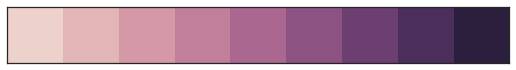

In [366]:
sns.choose_cubehelix_palette()

# 4-panel  plots, separated into core, edge, and outliers

## t-SNE scatter plots

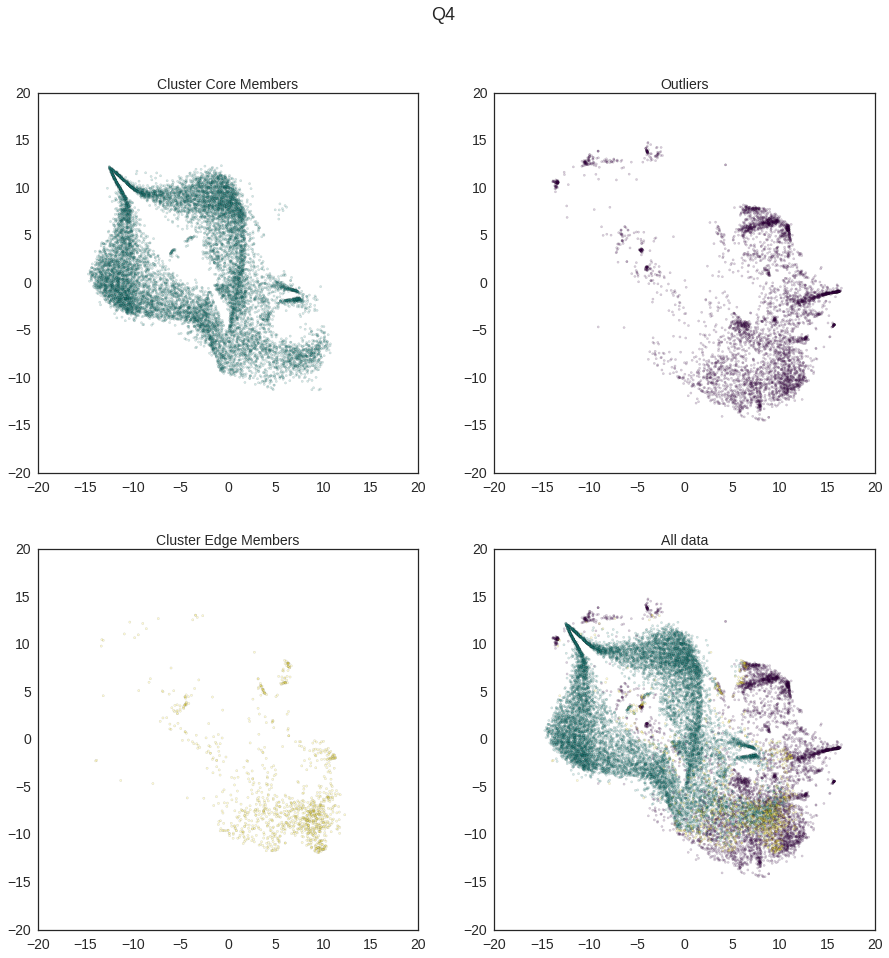

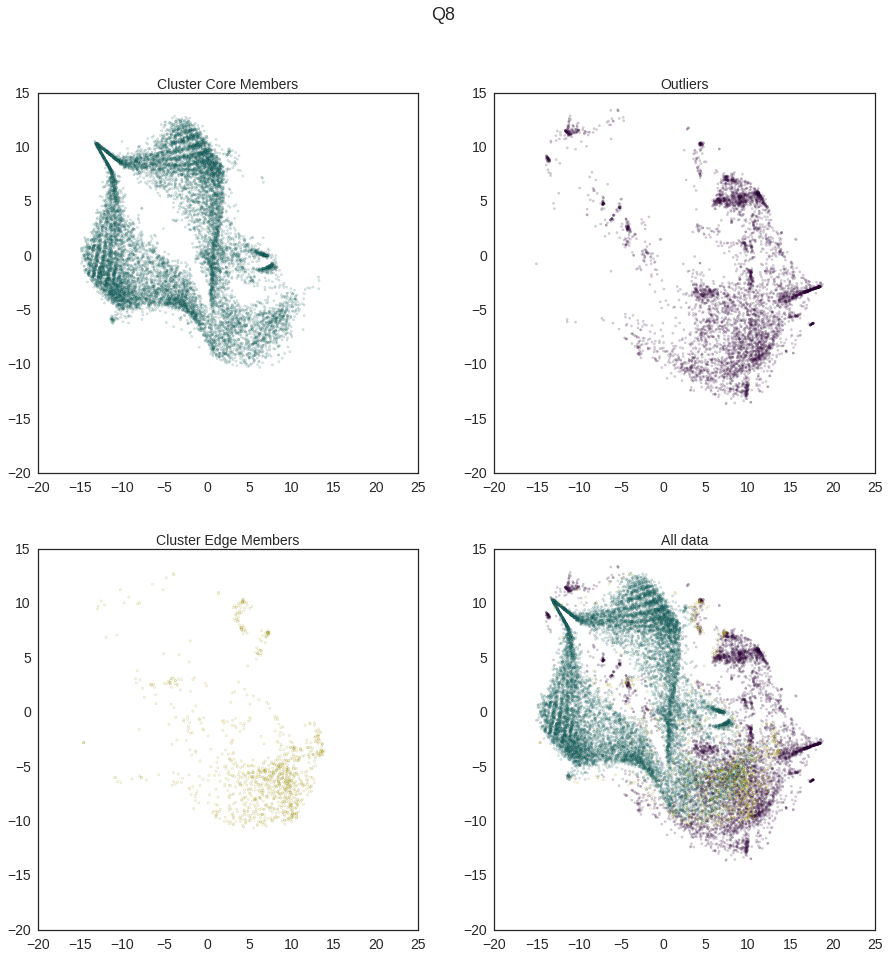

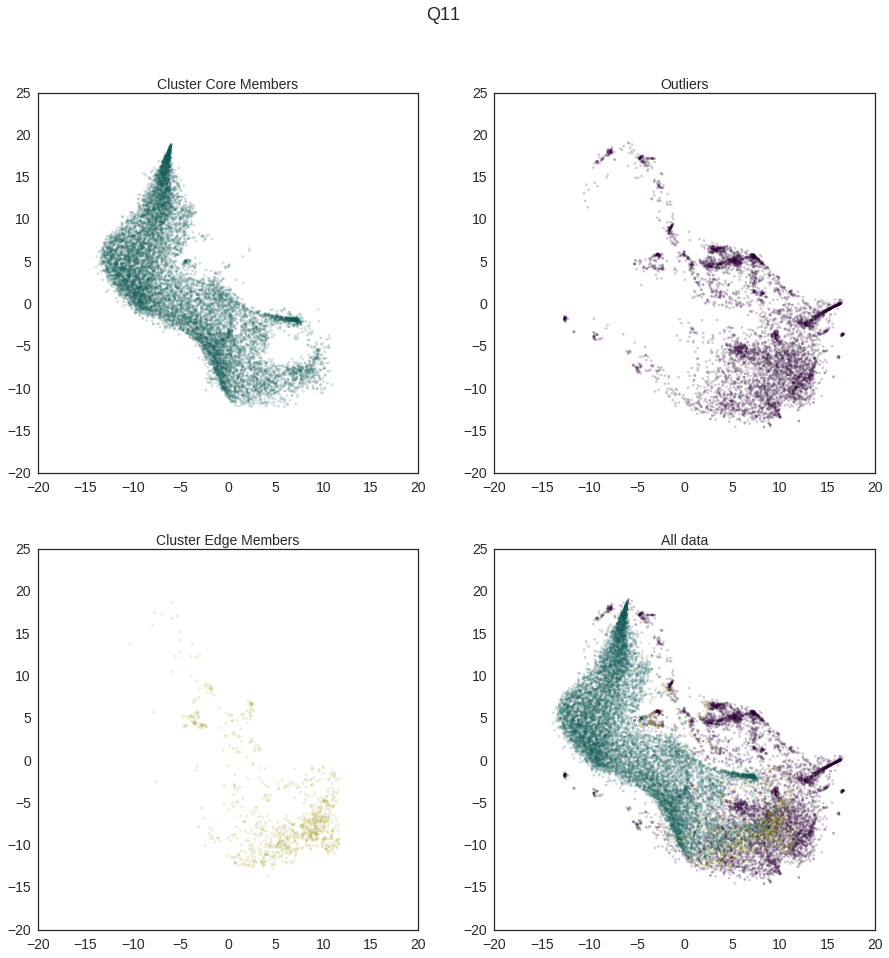

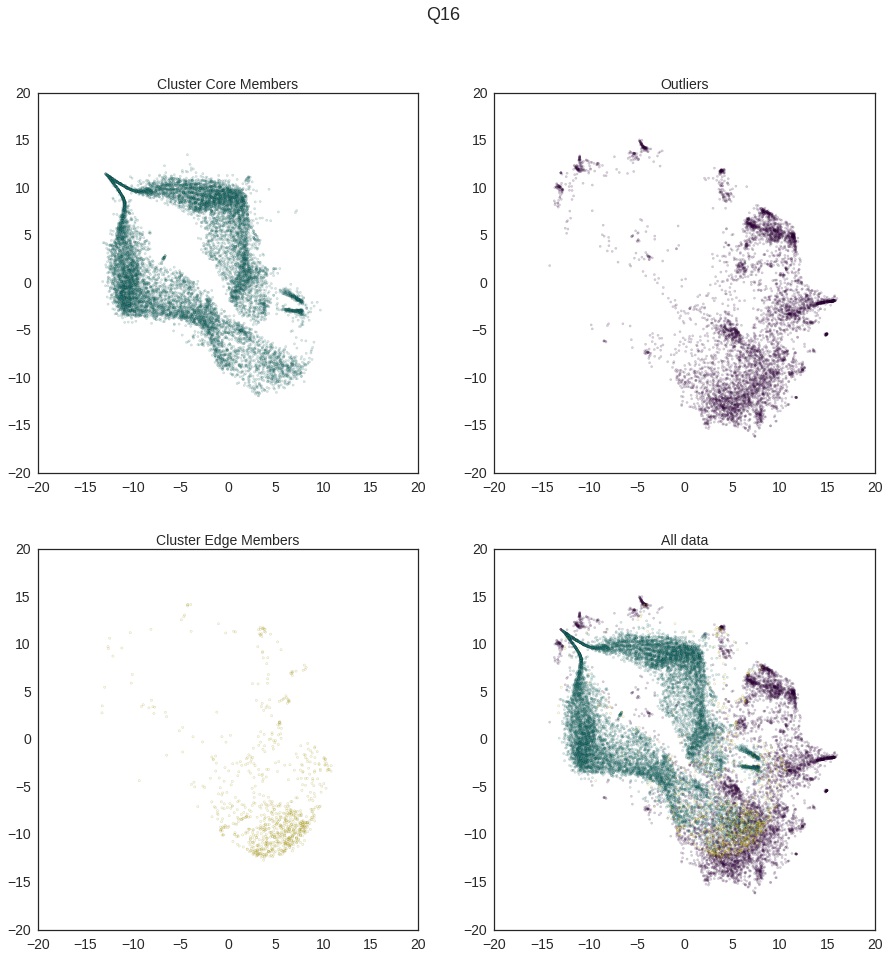

In [249]:
four_panel(Q4_sample.data,types='ssss',alpha=.2,title='Q4')
#"""
four_panel(Q8_sample.data,types='ssss',alpha=.2,title='Q8')
four_panel(Q11_sample.data,types='ssss',alpha=.2,title='Q11')
four_panel(Q16_sample.data,types='ssss',alpha=.2,title='Q16')
#"""

## KDE plots

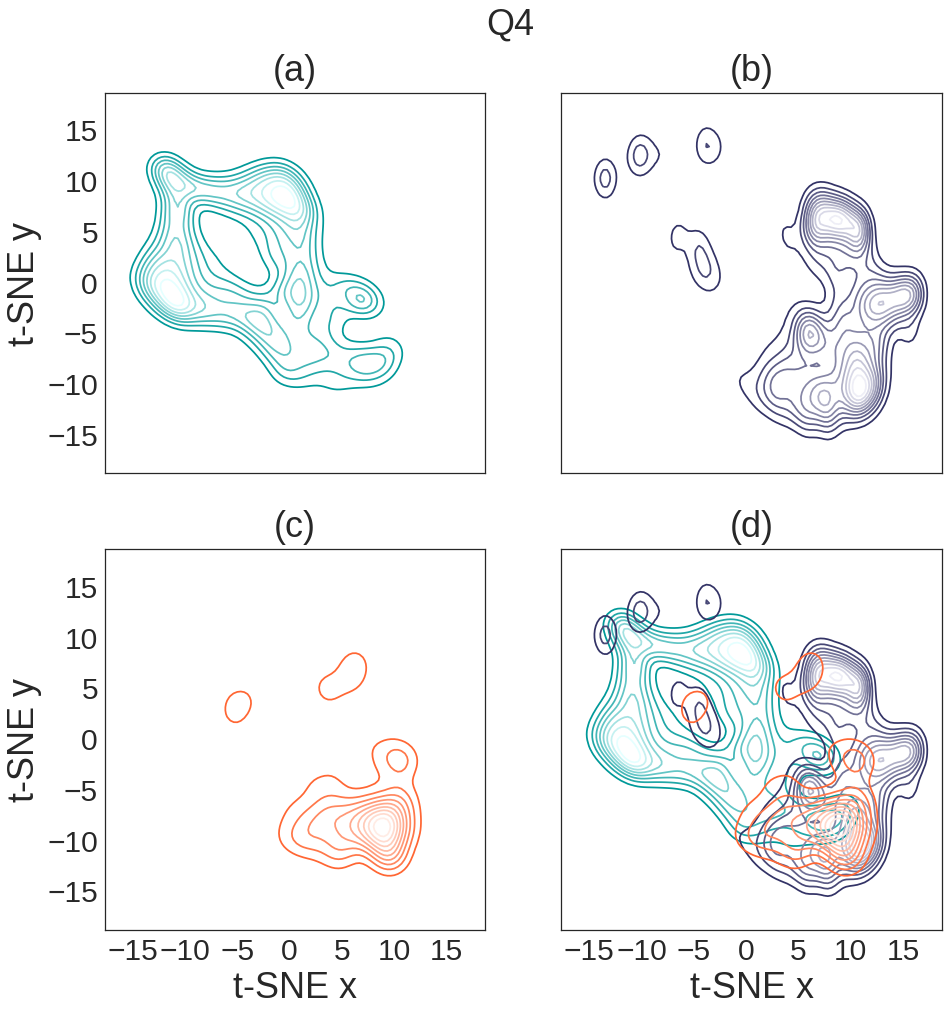

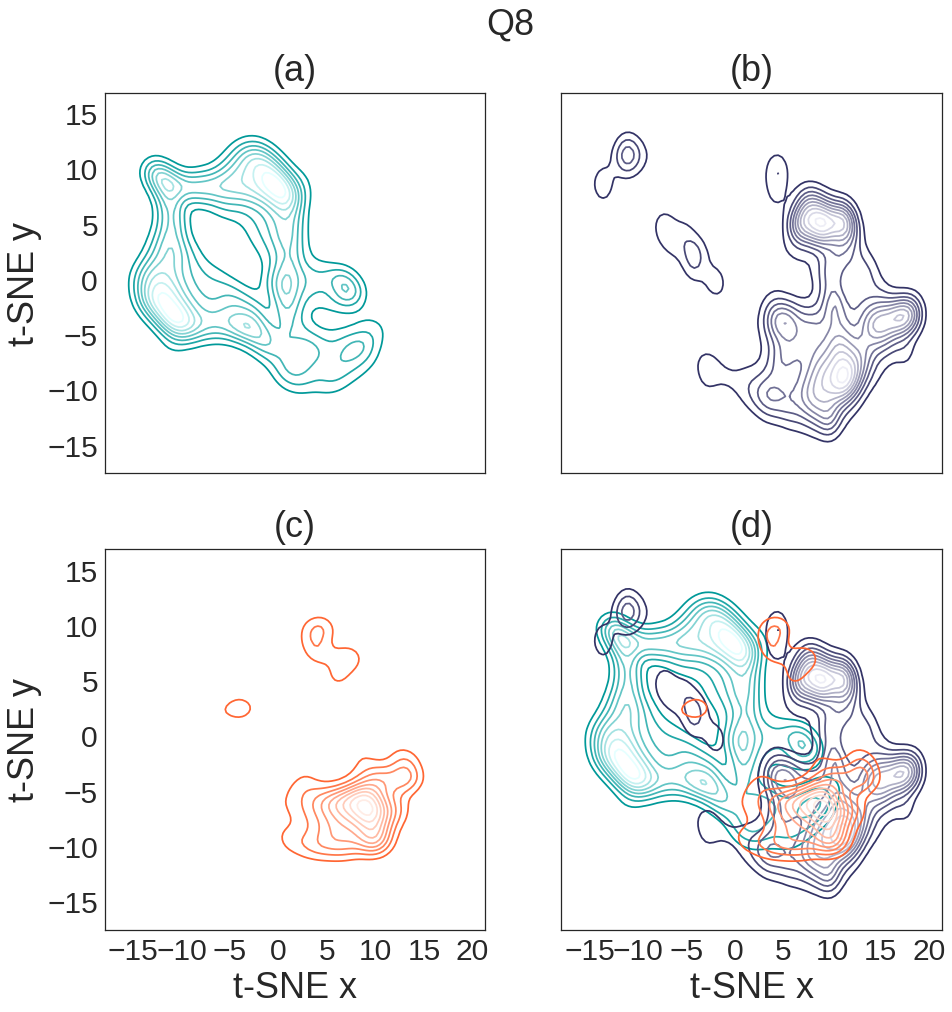

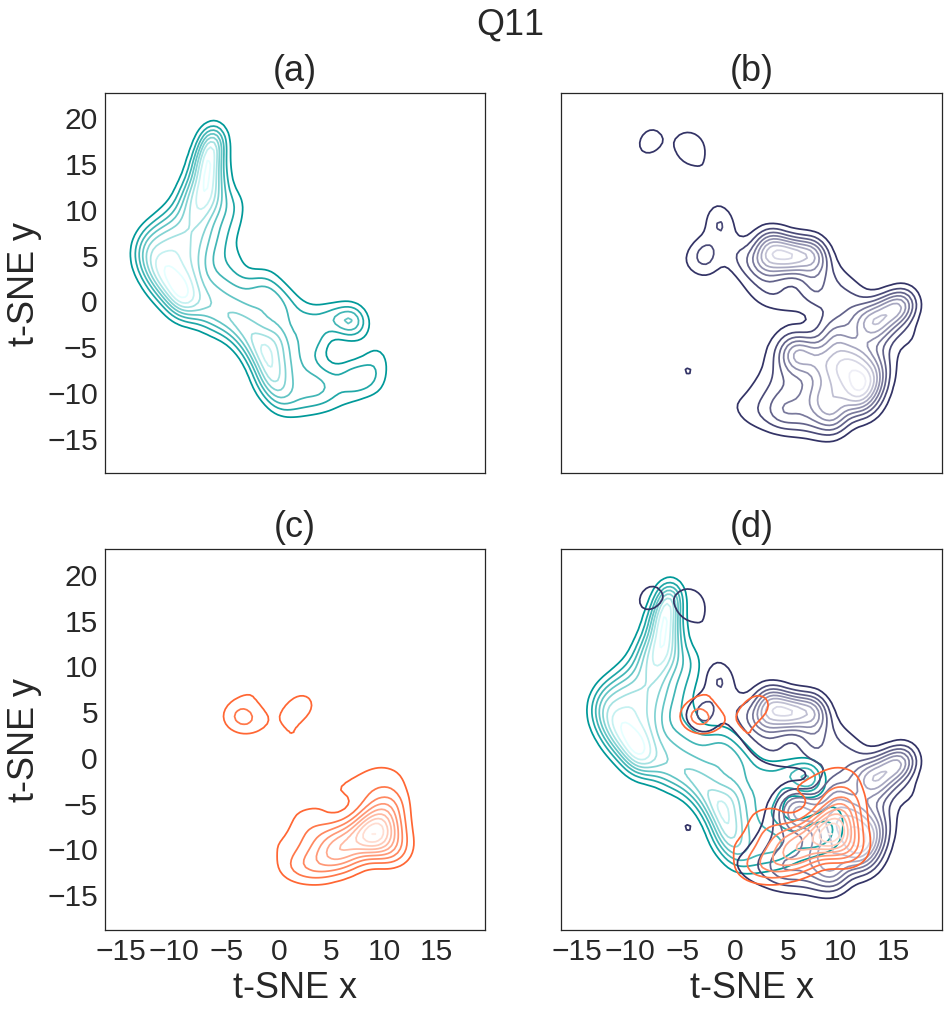

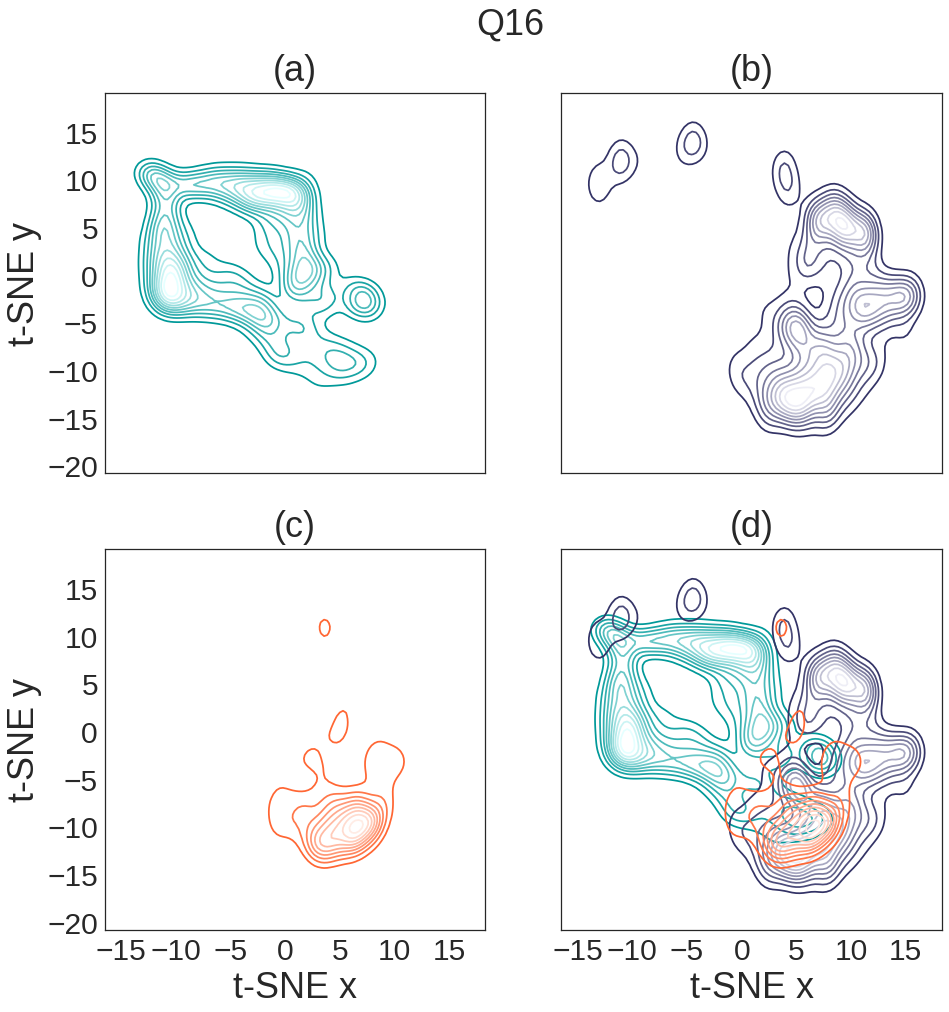

In [39]:
color_blind = [sns.light_palette("#009999",reverse=True,as_cmap=True),
               sns.light_palette("#FF6633",reverse=True,as_cmap=True),
               sns.light_palette("#333366",reverse=True,as_cmap=True)]


four_panel(Q4_sample.data,types='kkkk',title='Q4',
           col_clus=color_blind[0],shade_clus=False,
           col_out=color_blind[2],shade_out=False,
           col_edge=color_blind[1],shade_edge=False)
plt.savefig('Q4_4panel_KDE')
four_panel(Q8_sample.data,types='kkkk',title='Q8',
           col_clus=color_blind[0],shade_clus=False,
           col_out=color_blind[2],shade_out=False,
           col_edge=color_blind[1],shade_edge=False)
plt.savefig('Q8_4panel_KDE')
four_panel(Q11_sample.data,types='kkkk',title='Q11',
           col_clus=color_blind[0],shade_clus=False,
           col_out=color_blind[2],shade_out=False,
           col_edge=color_blind[1],shade_edge=False)
plt.savefig('Q11_4panel_KDE')
four_panel(Q16_sample.data,types='kkkk',title='Q16',
           col_clus=color_blind[0],shade_clus=False,
           col_out=color_blind[2],shade_out=False,
           col_edge=color_blind[1],shade_edge=False)
plt.savefig('Q16_4panel_KDE')


# Pts of interest

In [7]:
def tsne_kde(data,hl=['8462852'],
             col_clus="#009999",shade_clus=False,
             col_edge="#FF6633",shade_edge=False,
             col_out="#333366",shade_out=False,
             c=None,cmap=None,shade=False,k_alpha=1,ax=False,
            scatter=False):
    """
    args:
        data - data frame of data to be plotted containing tsne reduction
        hl - list of strings of data to highlight, defaults to highlight only Tabby's Star
        col_* - a color hex value
        shade_* - Boolean
    Use:
        For creating kde plots with points of interest highlighted and labelled
    """
    
    """
    col_clus=sns.dark_palette(col_clus,reverse=True,as_cmap=True)
    col_out=sns.dark_palette(col_out,reverse=True,as_cmap=True)
    col_edge=sns.dark_palette(col_edge,reverse=True,as_cmap=True)
    #"""
    #"""
    col_clus=sns.light_palette(col_clus,reverse=True,as_cmap=True)
    col_out=sns.light_palette(col_out,reverse=True,as_cmap=True)
    col_edge=sns.light_palette(col_edge,reverse=True,as_cmap=True)
    #"""
    
    
    """
    col_clus=sns.cubehelix_palette(n_colors=6,start=1.8,rot=.1,gamma=.7,hue=1.0,light=.7,dark=.3,reverse=False,as_cmap=True)
    col_edge=sns.cubehelix_palette(n_colors=6,start=.8,rot=.3,gamma=.7,hue=1.0,light=.7,dark=.3,reverse=False,as_cmap=True)
    col_out=sns.cubehelix_palette(n_colors=6,start=0,rot=.3,gamma=1.0,hue=1.0,light=.7,dark=.3,reverse=False,as_cmap=True)
    
    #"""
    if not ax:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        
    labels = data.db_out
    outliers = data[labels==-1]
    core = data[labels==0]
    edge = data[labels==1]
    colorVal = colors_for_plot(labels,cmap='color_blind')
    titlesize = 30 
    ticksize = 24
    # Using the panel method defined for this work
    panel(core[core.tsne_x<40],cmap=col_clus,shade=shade_clus,t='k',ax=ax)
    panel(outliers[outliers.tsne_x<40],cmap=col_out,shade=shade_out,t='k',ax=ax)
    panel(edge[edge.tsne_x<40],cmap=col_edge,shade=shade_edge,t='k',ax=ax)
    if scatter:
        ax.scatter(data[data.tsne_x>30].tsne_x,data[data.tsne_x>30].tsne_y,
                   c=colorVal[data.tsne_x>40],s=30)
        
    legend_cs = colors_for_plot([0,1,-1],cmap='color_blind')
    ax.scatter([],[],c=legend_cs[-1],s=50,label='Outliers')
    ax.scatter([],[],c=legend_cs[0],s=50,label='Core Cluster')
    ax.scatter([],[],c=legend_cs[1],s=50,label='Edge Cluster')
    ax.legend(scatterpoints=1,loc=4)
    
    out_samp = make_sampler(hl)
    hl_data = out_samp(data)
    annotatePts(hl_data,ax=ax)
    ax.tick_params(labelsize=ticksize)
    ax.set_xlabel('t-SNE x',fontsize=titlesize)
    ax.set_ylabel('t-SNE y',fontsize=titlesize)
    

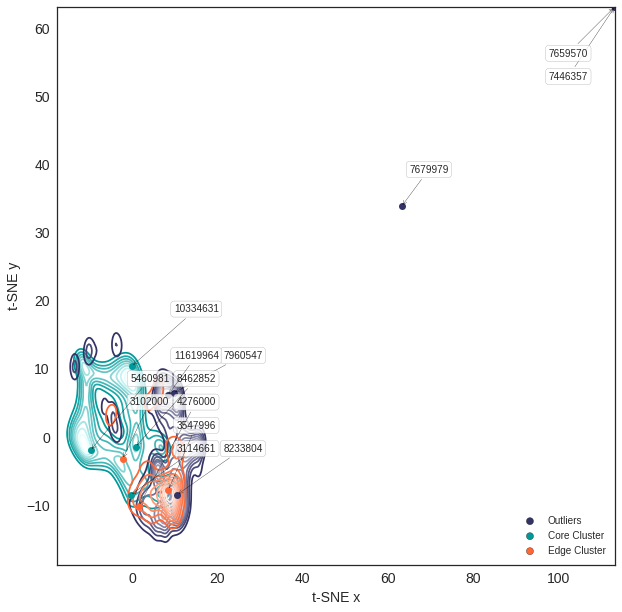

In [61]:
hllabels = np.concatenate([out_samp_inds,sup_out])
tsne_kde(Q4_sample.data,hl=hllabels)

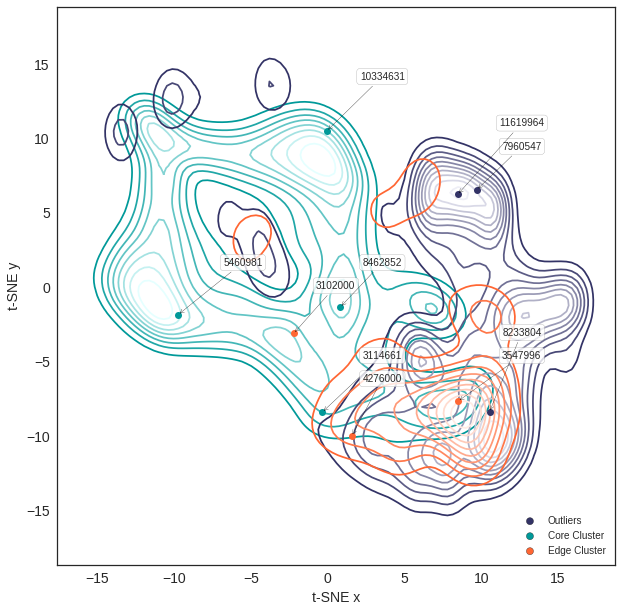

In [60]:
tsne_kde(Q4_sample.data,hl=out_samp_inds)

## Annotated KDE Plots

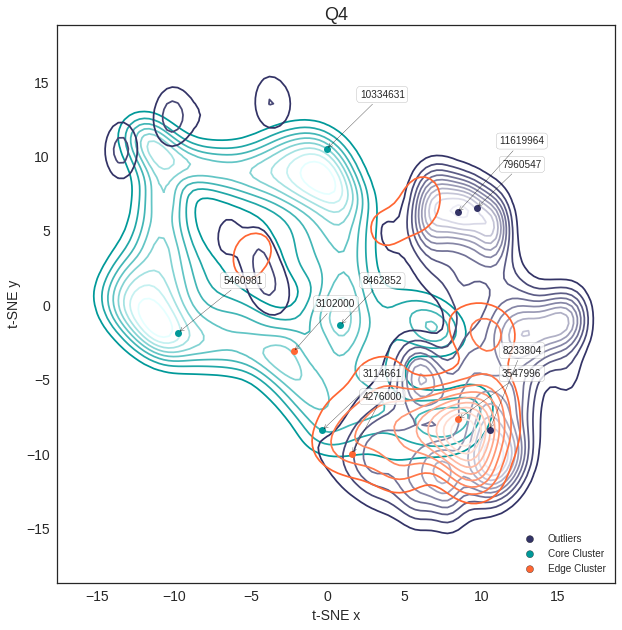

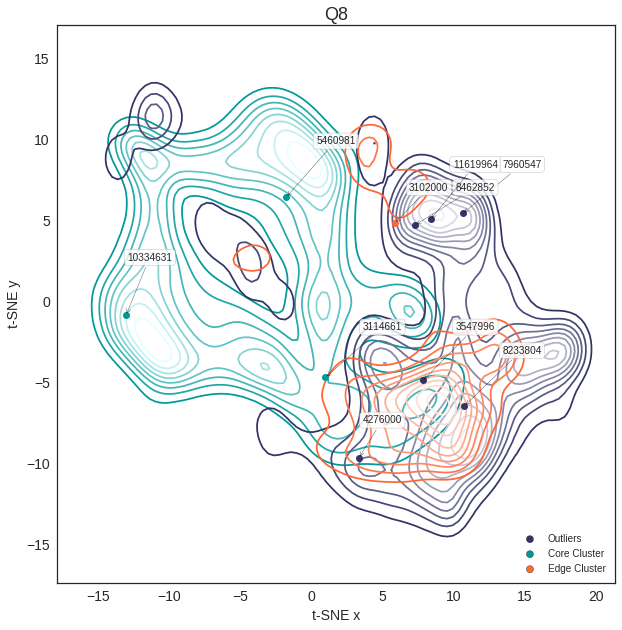

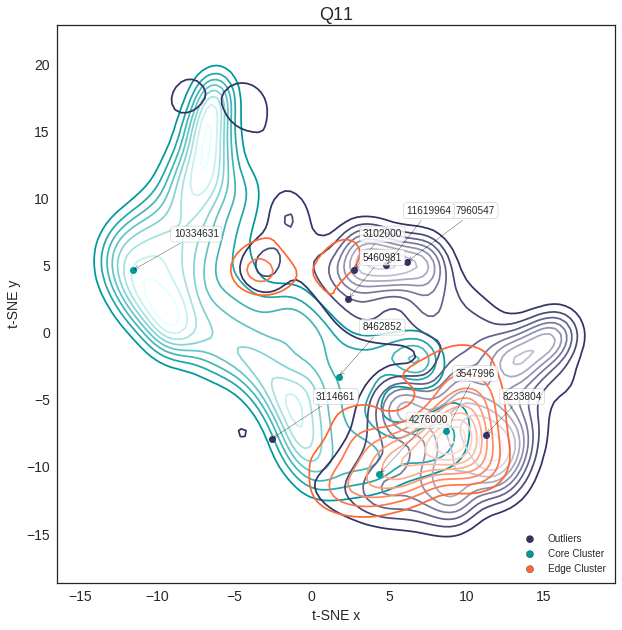

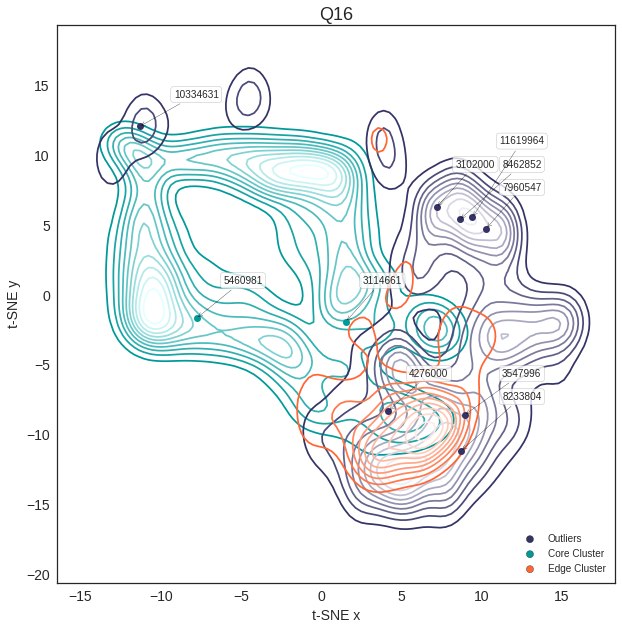

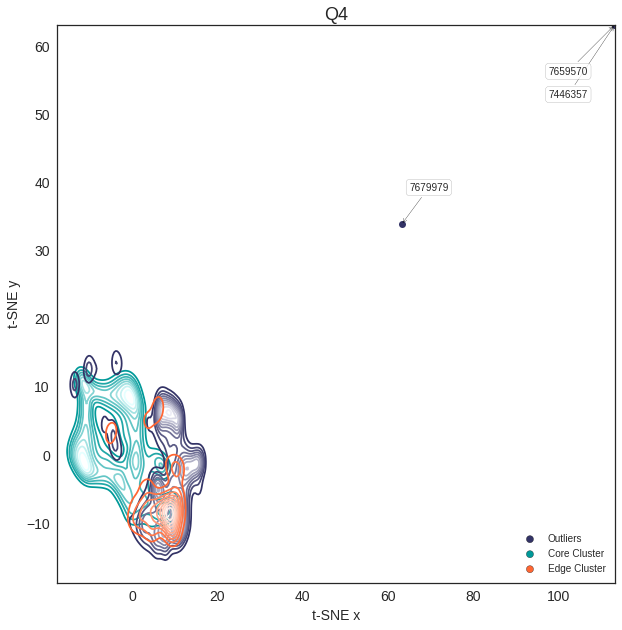

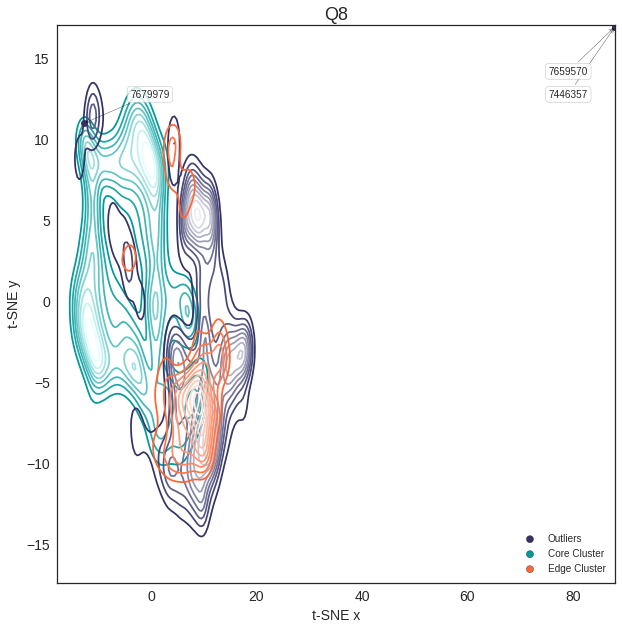

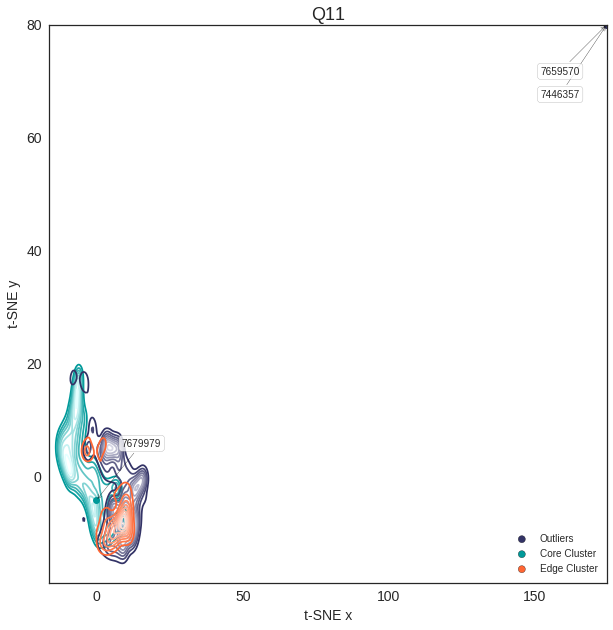

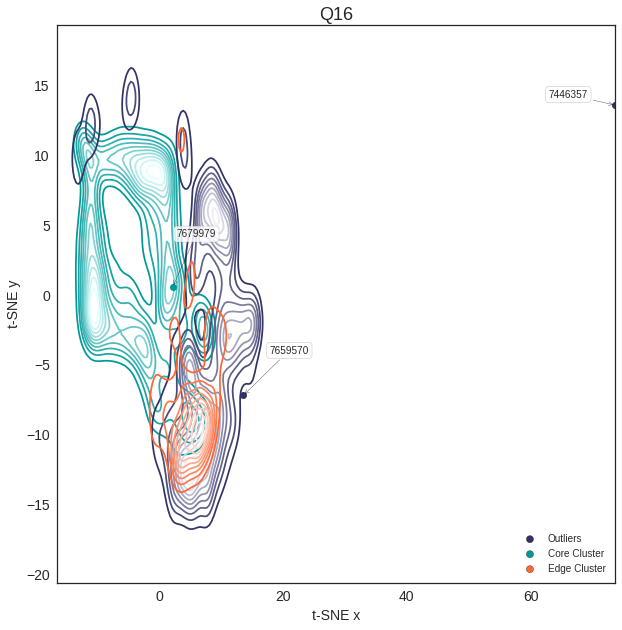

In [62]:
#out_inds_w_sup = np.concatenate([out_samp_inds,sup_out])
tsne_kde(Q4_sample.data,hl=out_samp_inds)
plt.title('Q4',fontsize=18)
plt.savefig('Q4_annotated_KDE')
tsne_kde(Q8_sample.data,hl=out_samp_inds)
plt.title('Q8',fontsize=18)
plt.savefig('Q8_annotated_KDE')
tsne_kde(Q11_sample.data,hl=out_samp_inds)
plt.title('Q11',fontsize=18)
plt.savefig('Q11_annotated_KDE')
tsne_kde(Q16_sample.data,hl=out_samp_inds)
plt.title('Q16',fontsize=18)
plt.savefig('Q16_annotated_KDE')


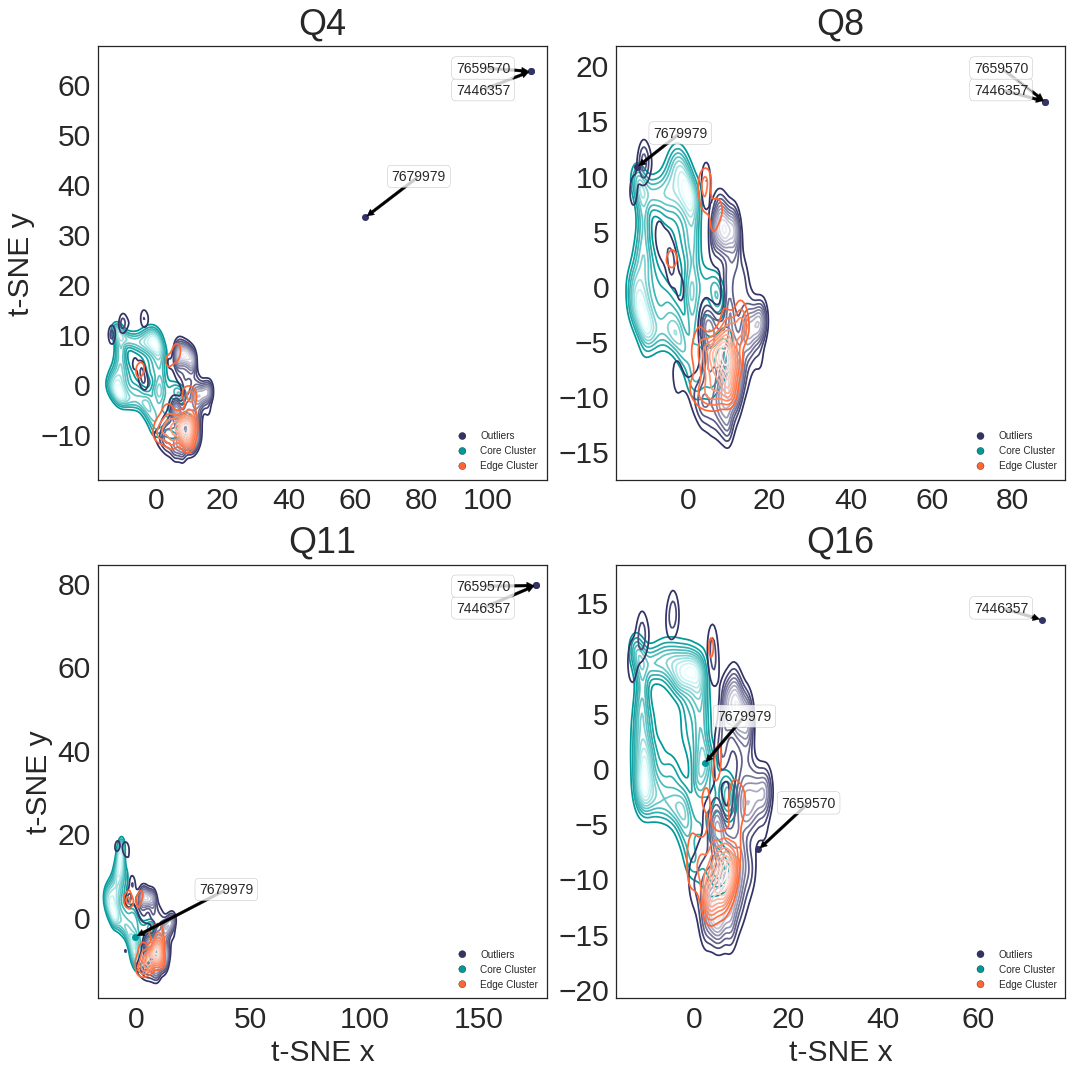

In [63]:
def annotatePts(hl_data,ax):
    """
    COPY OF annotatePts FROM ABOVE, FOR USE WITH SUPER OUTLIERS
    
    Annotate an axis with labels in small rounded boxes
    Args:
        X (np.array) - array of points, of shape (numPoints, 3)
        index (int) - index (into points array X) of item which should be printed
    Returns:
        None
    """
    
    def duplicates(z):
        """
        Checks for duplicate pts in n x 2 array z
        Args:
            z (nx2 np.array) - numpy array containing n, 2D pts
        Returns:
            Numpy array with each index containing indices of duplicate pts
        """
        x = z[:,0]
        y = z[:,1]
        # sorted indexes based on x's primarily, y secondarily
        idx_sort = np.lexsort((y,x))
        z_sorted = z[idx_sort]
        # unique elements, using z_sorted so the indices are returned in order
        u,idx = np.unique(z_sorted,axis=0,return_index=True)
        # Split sorted indices along unique indices
        idx_split = np.split(idx_sort,idx[1:])
        # Only care about duplicates
        dup_inds = filter(lambda x: x.size > 1,idx_split)
        return dup_inds
    
    def label_adjust(x,y,step):
        """
        Adjusts y-value of duplicate pts to avoid overlap.
        Args:
            x (numpy array, dtype=float) - array of x values
            y (numpy array, dtype=float) - array of y values
            step (float) - size of adjustment to make to y value of duplicate pts
        """
        z = np.stack([x,y],axis=1)
        dup_inds = duplicates(z)
        # making adjustments if there are duplicates
        if dup_inds !=[]:
            i = 1 # Safety net
            while dup_inds!=[]:
                for dup in dup_inds:
                    z[dup[1:]]+=[0,step]

                dup_inds = duplicates(z)

                i-=1
                if i>100:
                    break
        x=z[:,0]
        y=z[:,1]
        return x,y
    
    x_data = hl_data.tsne_x
    y_data = hl_data.tsne_y
    cs = colors_for_plot(hl_data.db_out,cmap='color_blind')
    
    # Pyplot Scatter doesn't plot over the KDE plot for some reason, pyplot plot does
    for i in range(len(x_data)):
        ax.plot(x_data[i],y_data[i],marker='o',c=cs[i])
    ax.set_xlim(ax.get_xlim()[0],max(x_data)+5)
    ax.set_ylim(ax.get_ylim()[0],max(y_data)+5)
    x_grid = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],8)
    y_grid = np.linspace(ax.get_ylim()[0],ax.get_ylim()[1],21) # creating a grid for labels to be situated on

    
    xt = np.array([x_grid[min(np.abs(x_grid-x).argmin()+1,len(x_grid)-2)] for x in x_data])
    yt = np.array([y_grid[min(np.abs(y_grid-y).argmin()+2,len(y_grid)-3)] for y in y_data])
    xt,yt = label_adjust(xt,yt,y_grid[1]-y_grid[0])

    for i,pt in enumerate(hl_data.index):
        """Arrows first, then text boxes"""
        an = ax.annotate('',
                         xy=(x_data[i],y_data[i]),xycoords='data',
                         xytext=(xt[i],yt[i]), textcoords='data',
                         ha='center',va='center', size=14,
                         arrowprops=dict(arrowstyle="simple",color='black'))    
    
    for i,pt in enumerate(hl_data.index):
        label = str(int(pt[4:13]))
        bbox_props = dict(boxstyle="round,pad=0.3",fc='w',ec='0.5',alpha=.8)
        an = ax.annotate(label,
                         xy=(x_data[i],y_data[i]),xycoords='data',
                         xytext=(xt[i],yt[i]), textcoords='data',
                         ha='center',va='center', size=14,
                         arrowprops=dict(arrowstyle="-"),bbox=bbox_props)    
        
sns.set_style('white')

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

titlesize = 36
ticksize = 30

# Panel 1
tsne_kde(Q4_sample.data,hl=sup_out,ax=ax1)
ax1.set_title('Q4',fontsize=titlesize,verticalalignment='bottom')
ax1.tick_params(labelsize=ticksize)
ax1.set_xlabel('',fontsize=ticksize)
ax1.set_ylabel('t-SNE y',fontsize=ticksize)

# Panel 2
tsne_kde(Q8_sample.data,hl=sup_out,ax=ax2)
ax2.set_title('Q8',fontsize=titlesize,verticalalignment='bottom')
ax2.tick_params(labelsize=ticksize)
ax2.set_xlabel('',fontsize=ticksize)
ax2.set_ylabel('',fontsize=ticksize)

# Panel 3
tsne_kde(Q11_sample.data,hl=sup_out,ax=ax3)
ax3.set_title('Q11',fontsize=titlesize,verticalalignment='bottom')
ax3.tick_params(labelsize=ticksize)
ax3.set_xlabel('t-SNE x',fontsize=ticksize)
ax3.set_ylabel('t-SNE y',fontsize=ticksize)

# Panel 4
tsne_kde(Q16_sample.data,hl=sup_out,ax=ax4)
ax4.set_title('Q16',fontsize=titlesize,verticalalignment='bottom')
ax4.tick_params(labelsize=ticksize)
ax4.set_xlabel('t-SNE x',fontsize=ticksize)
ax4.set_ylabel('',fontsize=ticksize)
plt.tight_layout()

plt.savefig('All quarters full')


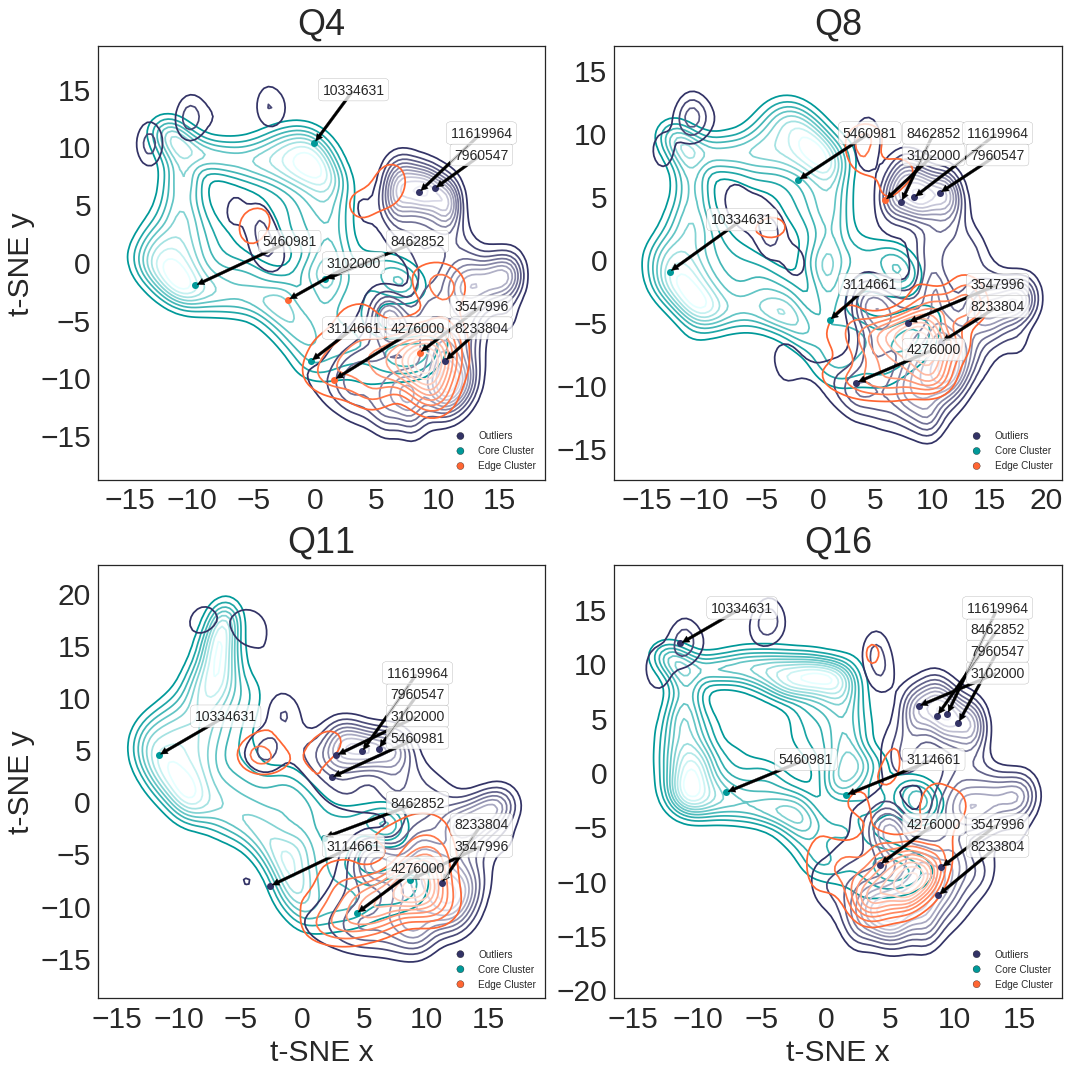

In [62]:
sns.set_style('white')

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

titlesize = 36
ticksize = 30

# Panel 1
tsne_kde(Q4_sample.data,hl=out_samp_inds,ax=ax1)
ax1.set_title('Q4',fontsize=titlesize,verticalalignment='bottom')
ax1.tick_params(labelsize=ticksize)
ax1.set_xlabel('',fontsize=ticksize)
ax1.set_ylabel('t-SNE y',fontsize=ticksize)

# Panel 2
tsne_kde(Q8_sample.data,hl=out_samp_inds,ax=ax2)
ax2.set_title('Q8',fontsize=titlesize,verticalalignment='bottom')
ax2.tick_params(labelsize=ticksize)
ax2.set_xlabel('',fontsize=ticksize)
ax2.set_ylabel('',fontsize=ticksize)

# Panel 3
tsne_kde(Q11_sample.data,hl=out_samp_inds,ax=ax3)
ax3.set_title('Q11',fontsize=titlesize,verticalalignment='bottom')
ax3.tick_params(labelsize=ticksize)
ax3.set_xlabel('t-SNE x',fontsize=ticksize)
ax3.set_ylabel('t-SNE y',fontsize=ticksize)

# Panel 4
tsne_kde(Q16_sample.data,hl=out_samp_inds,ax=ax4)
ax4.set_title('Q16',fontsize=titlesize,verticalalignment='bottom')
ax4.tick_params(labelsize=ticksize)
ax4.set_xlabel('t-SNE x',fontsize=ticksize)
ax4.set_ylabel('',fontsize=ticksize)
plt.tight_layout()
plt.savefig('All quarters annotated')


## Lightcurves

In [76]:
def read_kepler_curve(file):
    """
    Given the path of a fits file, this will extract the light curve and normalize it.
    """
    lc = fits.open(file)[1].data
    t = lc.field('TIME')
    f = lc.field('PDCSAP_FLUX')
    err = lc.field('PDCSAP_FLUX_ERR')

    err = err[np.isfinite(t)]
    f = f[np.isfinite(t)]
    t = t[np.isfinite(t)]
    err = err[np.isfinite(f)]
    t = t[np.isfinite(f)]
    f = f[np.isfinite(f)]
    err = err/np.median(f)
    nf = f / np.median(f)

    return t, nf, err

def plot_lc(file,filepath,c='blue',ax=False):
    """
    kid should be full id including time information
    Args:
        file (str) - filename starting with kplr ending in .fits
        filepath (str) - path to fits file
    Returns:
        None
    """
    if not ax:
        fig = plt.figure(figsize=(16,4))
        ax = fig.add_subplot(111)
    f = filepath+file
    
    t,nf,err=read_kepler_curve(f)

    x=t
    y=nf

    axrange=0.55*(max(y)-min(y))
    mid=(max(y)+min(y))/2
    yaxmin = mid-axrange
    yaxmax = mid+axrange
    if yaxmin < .95:
        if yaxmax > 1.05:
            ax.set_ylim(yaxmin,yaxmax)
        else:
            ax.set_ylim(yaxmin,1.05)
    elif yaxmax > 1.05:
        ax.set_ylim(.95,yaxmax)
    else:
        ax.set_ylim(.95,1.05)
        
    ax.set_xlim(min(x),max(x))
    color = c
    ax.plot(x, y, 'o',markeredgecolor='none', c=color, alpha=0.2)
    ax.plot(x, y, '-',markeredgecolor='none', c=color, alpha=0.7)
    #ax2.set_title(files[index][:13],fontsize = 20)
    ax.set_xlabel('Time (Days)',fontsize=22)
    ax.set_ylabel(r'$\frac{\Delta F}{F}$',fontsize=25)
    ax.tick_params(labelsize=20)
    #ax.set_title('KID'+str(int(file[4:13])),fontsize=25)
    
def four_Q_lc(kid):
    fig = plt.figure(figsize=(12,12))
    
    title_text = 'KID '+str(int(kid[4:13]))
    
    ax1 = fig.add_subplot(411)
    plt.title(title_text,fontsize=25)

    ax2 = fig.add_subplot(412)
    ax3 = fig.add_subplot(413)
    ax4 = fig.add_subplot(414)
    sampler =  make_sampler([kid])
    Q4ID = sampler(Q4_sample.data)
    Q8ID = sampler(Q8_sample.data)
    Q11ID = sampler(Q11_sample.data)
    Q16ID = sampler(Q16_sample.data)
    cs = colors_for_plot([Q4ID.db_out[0],Q8ID.db_out[0],Q11ID.db_out[0],Q16ID.db_out[0]],cmap='color_blind')
    
        
    plot_lc(Q4ID.index[0],filepath=Q4.fitsDir,c=cs[0],ax=ax1)
    plot_lc(Q8ID.index[0],filepath=Q8.fitsDir,c=cs[1],ax=ax2)
    plot_lc(Q11ID.index[0],filepath=Q11.fitsDir,c=cs[2],ax=ax3)
    plot_lc(Q16ID.index[0],filepath=Q16.fitsDir,c=cs[3],ax=ax4)
    
    legend_cs = colors_for_plot([0,1,-1],cmap='color_blind')
    ax4.scatter([],[],c=legend_cs[-1],s=50,label='Outliers')
    ax4.scatter([],[],c=legend_cs[0],s=50,label='Core Cluster')
    ax4.scatter([],[],c=legend_cs[1],s=50,label='Edge Cluster')
    ax4.legend(scatterpoints=1,loc=4)
    
    fig.tight_layout()


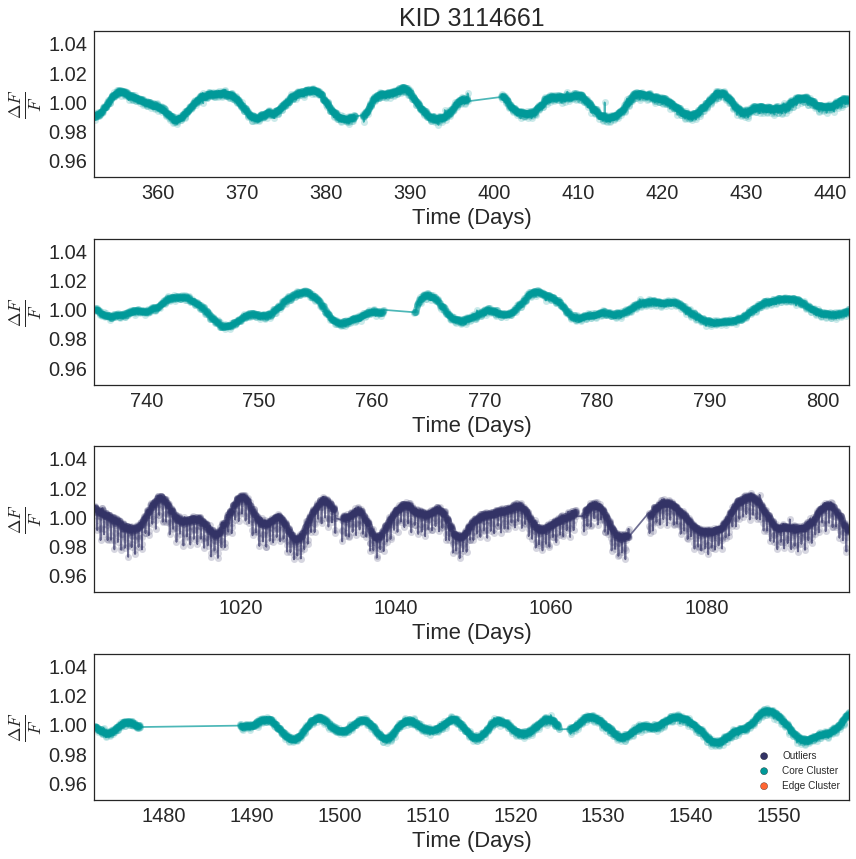

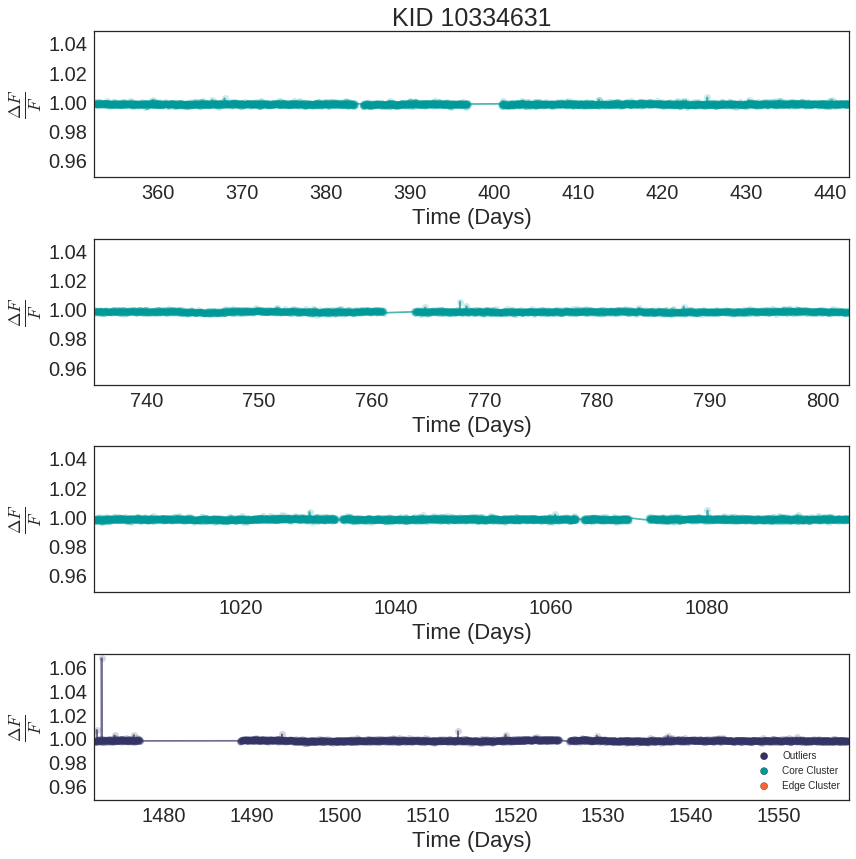

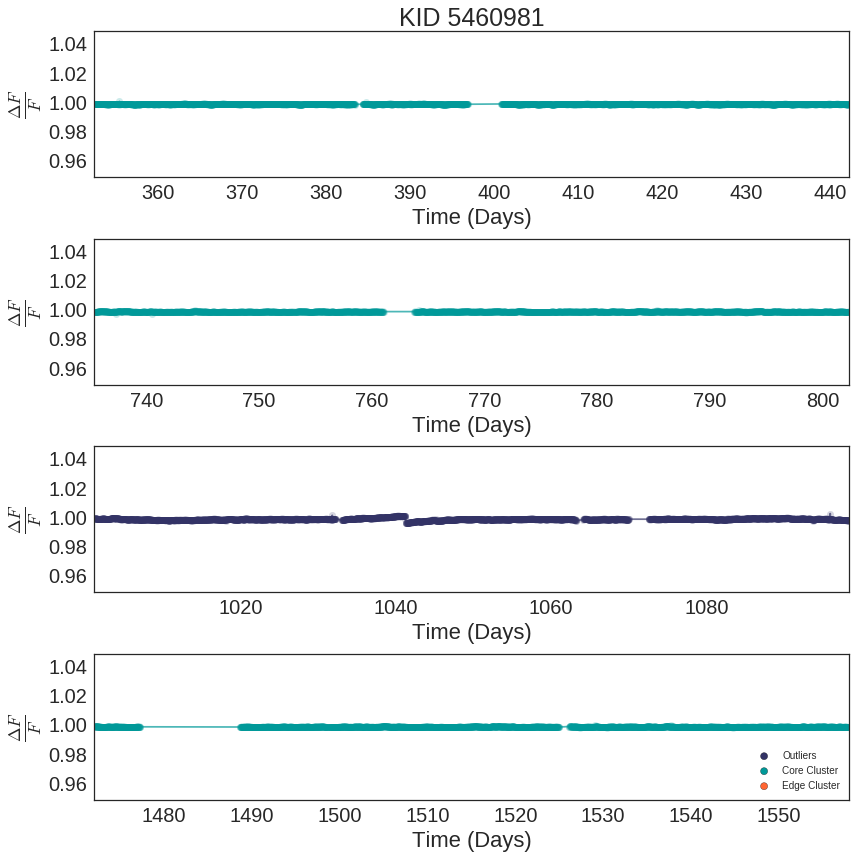

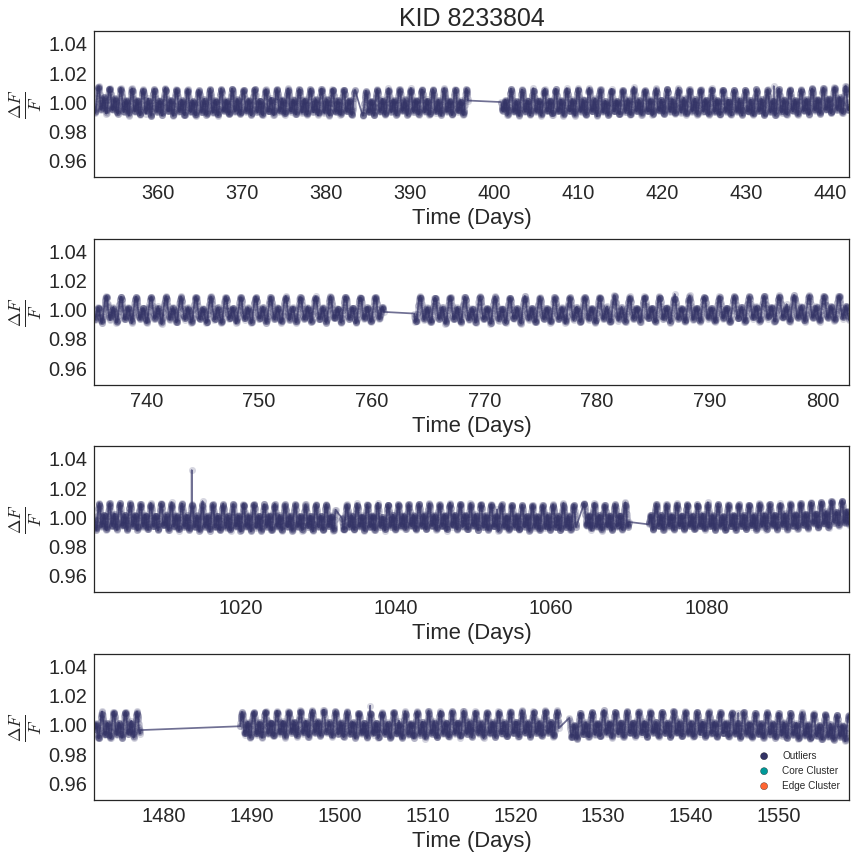

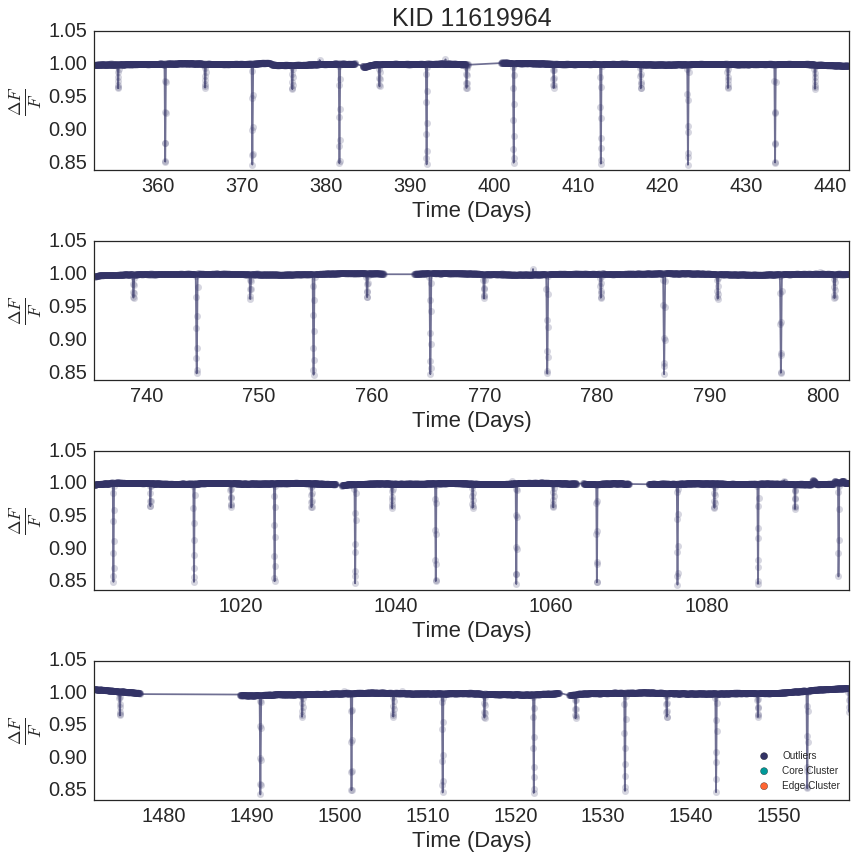

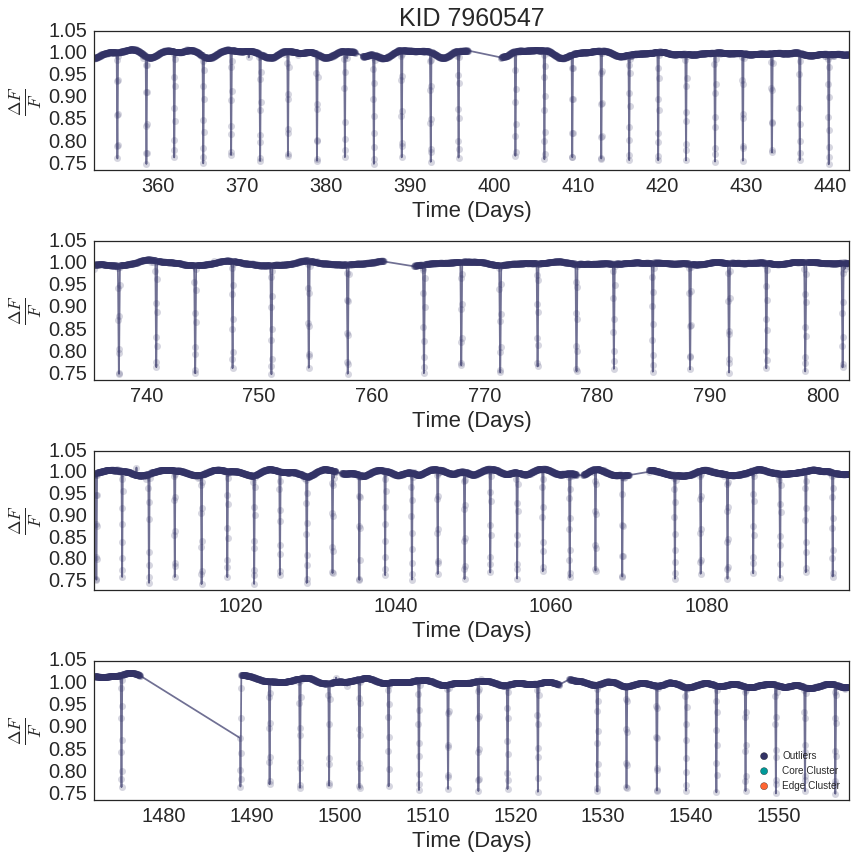

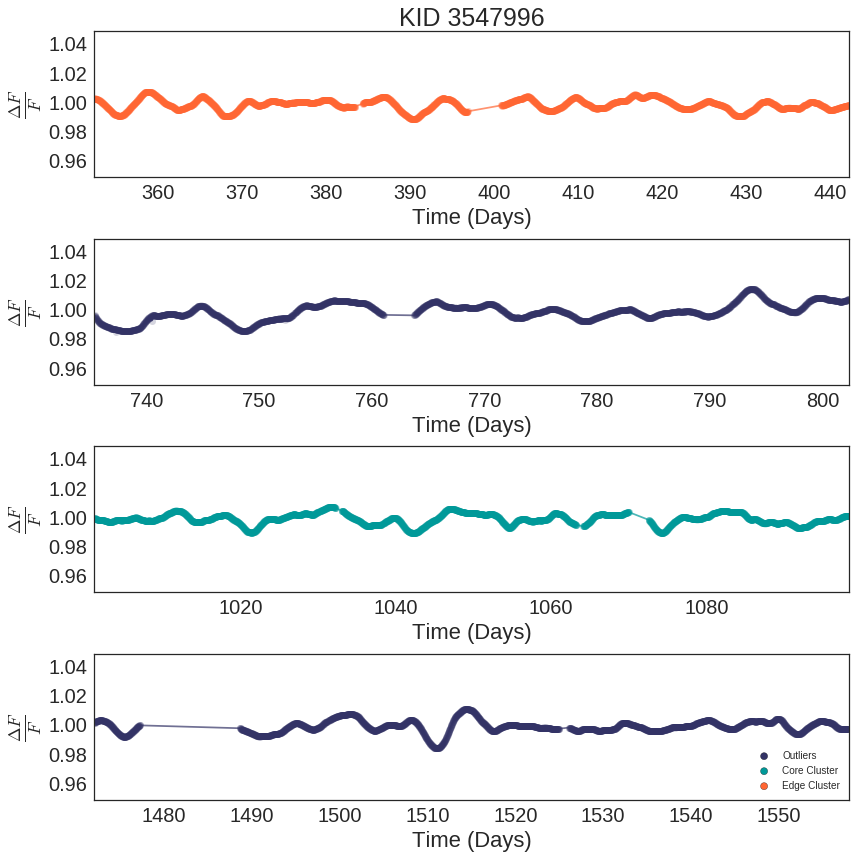

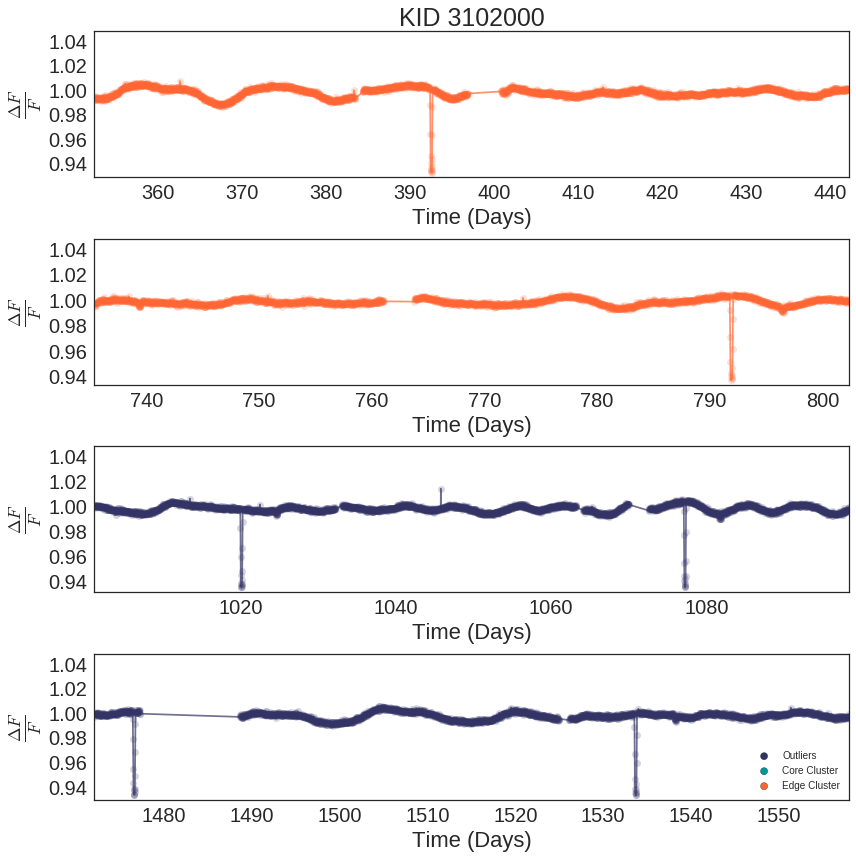

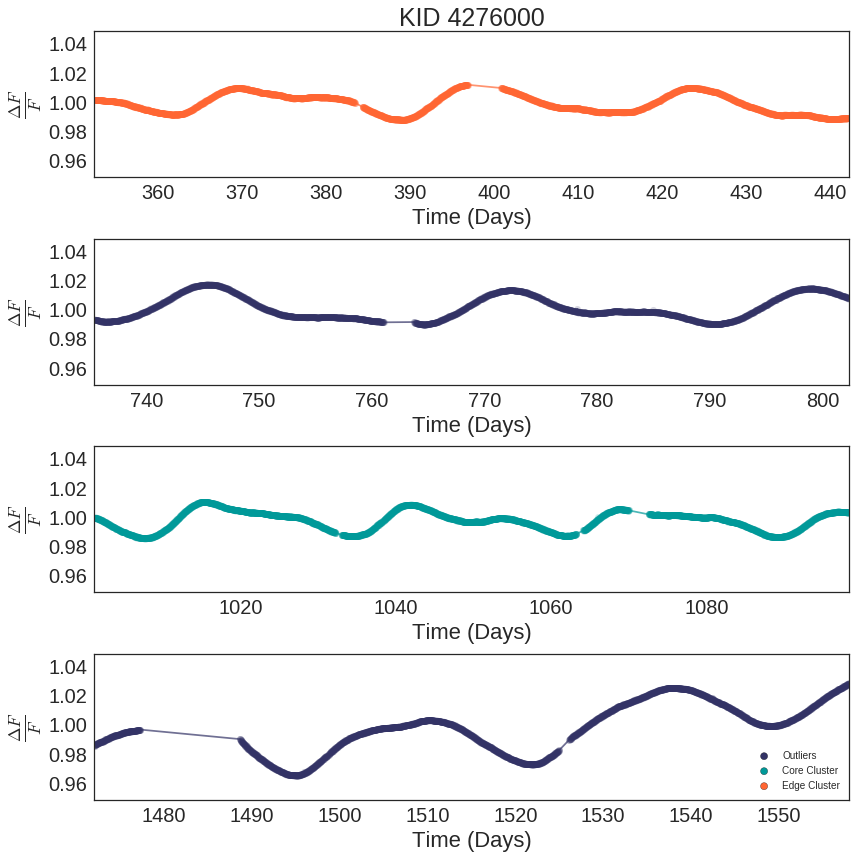

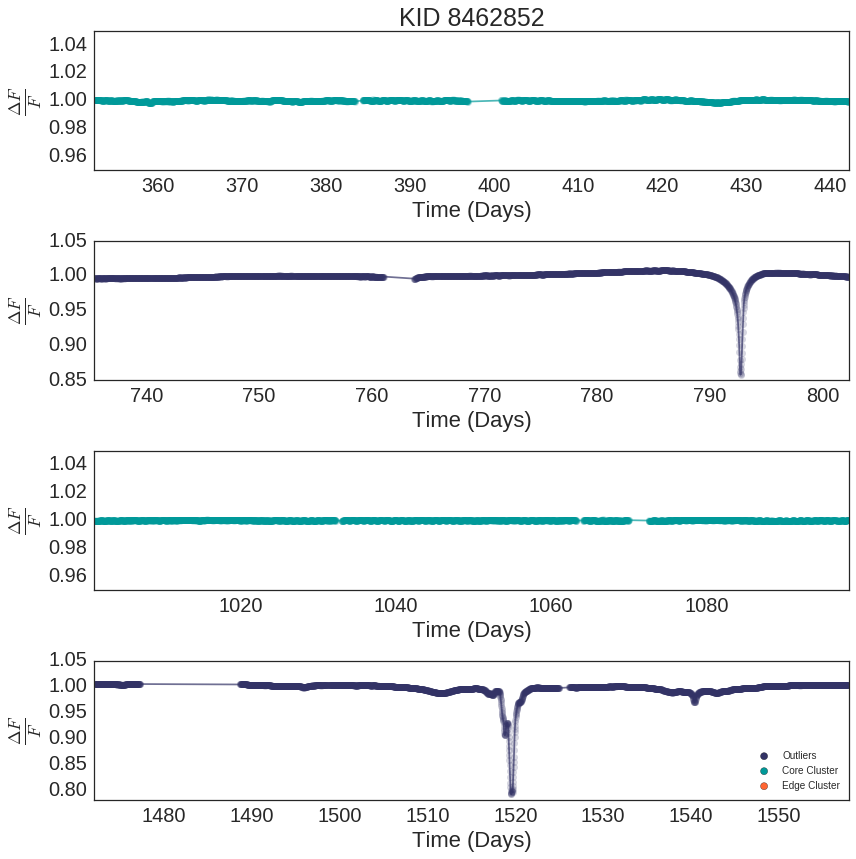

In [77]:
for kid in out_samp_inds:
    four_Q_lc(kid)
    plt.savefig(kid+'_4Q_LCs')

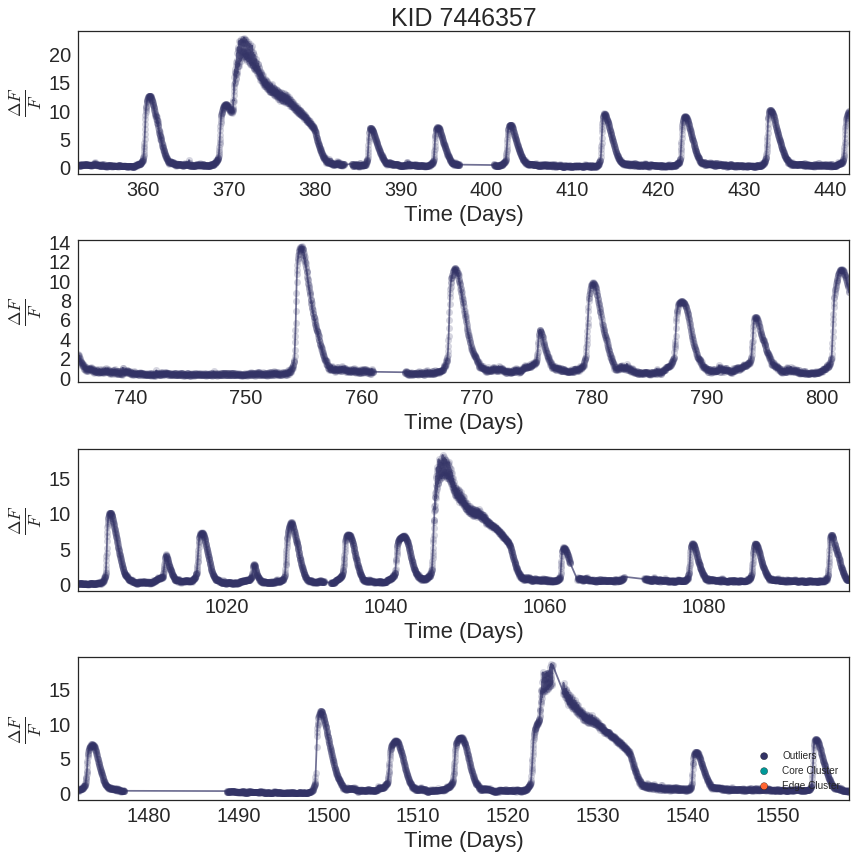

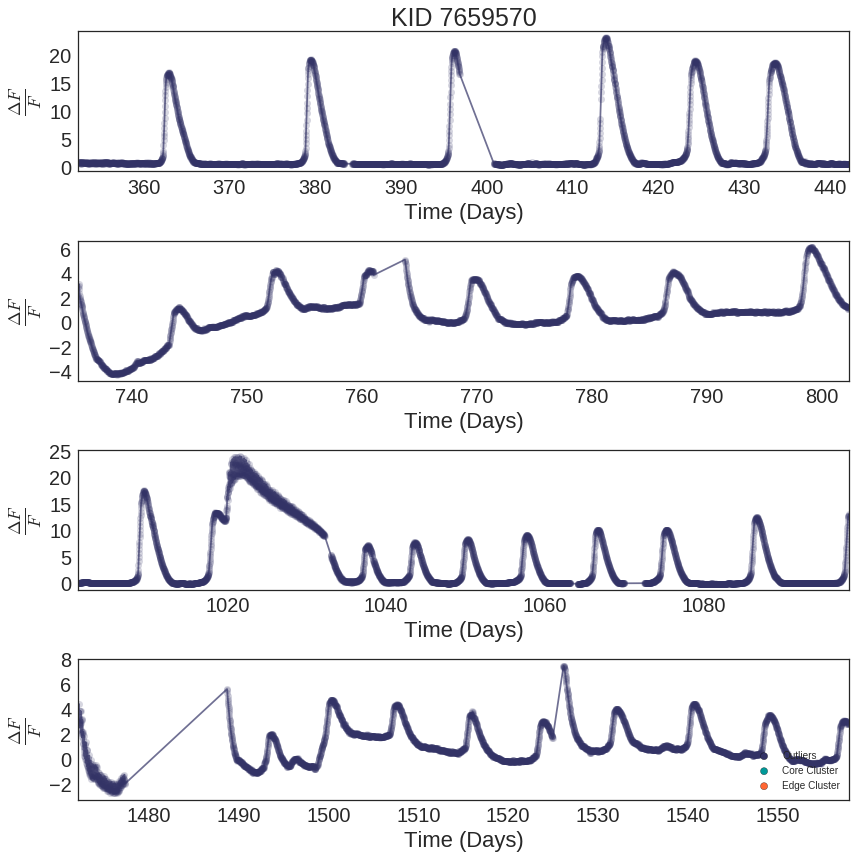

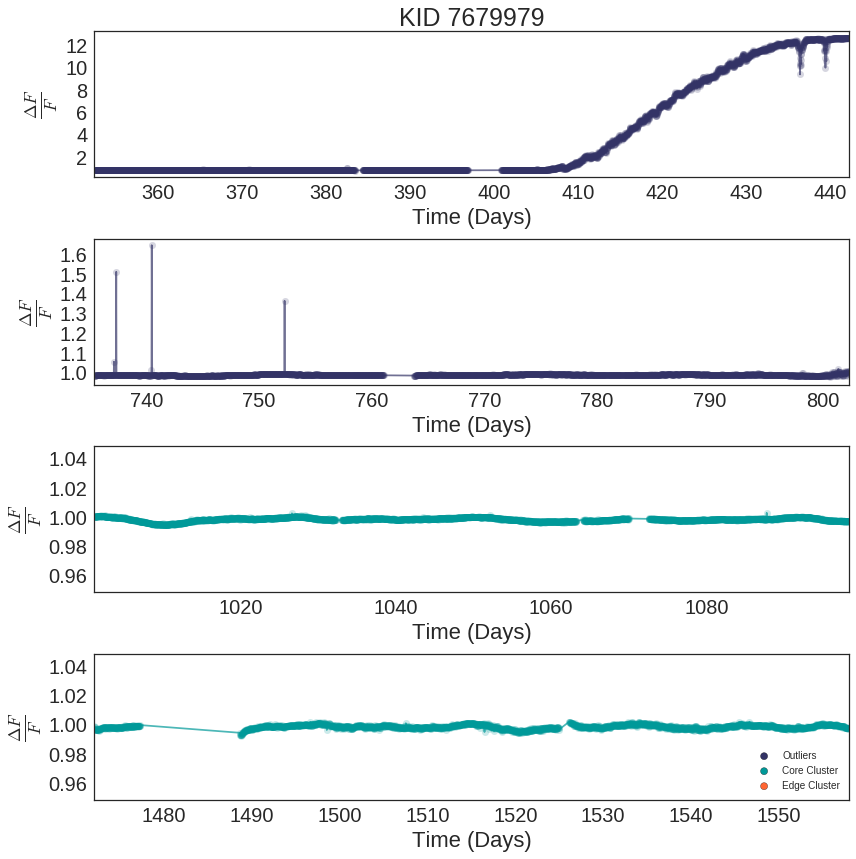

In [78]:
sup_out = Q4_sample.data[Q4_sample.data.tsne_x>40].KID
for kid in sup_out:
    four_Q_lc(kid)
    plt.savefig(kid+'_4Q_LCs')

# Stats of interest

In [54]:
# Number of outliers in each quarter
for q in Q_dict:
    print(q,len(Q_dict[q].data[Q_dict[q].data.db_out==-1]))

('Q8', 5041)
('Q16', 5750)
('Q11', 5879)
('Q4', 4866)


In [56]:
# create column containing only KID, no timestamp/quarter info
for q in Q_dict:
    data = Q_dict[q].data
    Q_dict[q].data['KID']=[i[:13] for i in Q_dict[q].data.index]
    
# A numpy arrays containing all kID's for data ID'd as outliers
kid_out=dict()
for q in Q_dict:
    kid_out[q]=Q_dict[q].data.KID[Q_dict[q].data.db_out==-1]

# Outliers in any quarter, not necessarily in all quarters
out_all = np.unique(np.concatenate([kid_out[q] for q in kid_out]))

print("""
Number of lightcurves identified as an outlier in at least one quarter {:}
""".format(len(out_all)))
print("""
As a percent of total lightcurves ({:}/{:}) {:.2f}%
""".format(len(out_all),
           len(Q4.data),
           float(len(out_all))/float(len(Q4.data))*100.))


Number of lightcurves identified as an outlier in at least one quarter 8507


As a percent of total lightcurves (8507/149789) 5.68%



In [57]:
# Identify outliers that are exclusive to each quarter, i.e. not an outlier in any other quarter
exc = dict()
for q in kid_out:
    out = kid_out[q]
    for p in kid_out:
        if q!=p:
            out = np.setdiff1d(out,kid_out[p])
    exc[q]=out
    print("""
    Number of lightcurves identified outliers only in {:s}: {:d}
    As a percent of quarter outliers ({:d}/{:d}): {:.2f}%
    As a percent of total outliers ({:d}/{:d}): {:.2f}%
    """.format(q,len(exc[q]),
              len(exc[q]),len(kid_out[q]),float(len(exc[q]))/float(len(kid_out[q]))*100.,
              len(exc[q]),len(Q4.data),float(len(exc[q]))/float(len(Q4.data))*100.
              ))


    Number of lightcurves identified outliers only in Q8: 624
    As a percent of quarter outliers (624/5041): 12.38%
    As a percent of total outliers (624/149789): 0.42%
    

    Number of lightcurves identified outliers only in Q16: 1043
    As a percent of quarter outliers (1043/5750): 18.14%
    As a percent of total outliers (1043/149789): 0.70%
    

    Number of lightcurves identified outliers only in Q11: 1147
    As a percent of quarter outliers (1147/5879): 19.51%
    As a percent of total outliers (1147/149789): 0.77%
    

    Number of lightcurves identified outliers only in Q4: 560
    As a percent of quarter outliers (560/4866): 11.51%
    As a percent of total outliers (560/149789): 0.37%
    


In [100]:
# Identify outliers that are ubiquitous to each quarter
out = kid_out['Q4'] # start w/ Q4
for q in kid_out: # loop through remaining Q's to check overlap
    if q!='Q4': 
        out = np.intersect1d(out,kid_out[q])

ub_out = out
print("""
Number of lightcurves identified as outliers in all quarters: {:d}
As a percent of all outliers ({:d}/{:d}): {:.2f}%
As a percent of all lightcurves ({:d}/{:d}): {:.2f}%
""".format(len(out),
          len(out),len(kid_out[q]),float(len(out))/float(len(out_all))*100.,
          len(out),len(Q4.data),float(len(out))/float(len(Q4.data))*100.
          ))


Number of lightcurves identified as outliers in all quarters: 3584
As a percent of all outliers (3584/4866): 42.13%
As a percent of all lightcurves (3584/149789): 2.39%



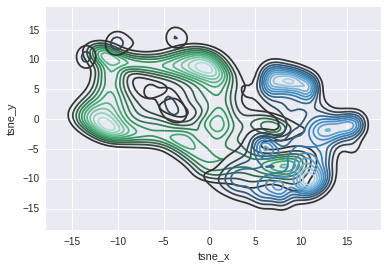

In [45]:
%matplotlib inline
inliers = Q4_sample.data[Q4_sample.data.db_out>=0]
outliers = Q4_sample.data[Q4_sample.data.db_out==-1]
sns.kdeplot(inliers[inliers.tsne_x<40].tsne_x,
            inliers[inliers.tsne_x<40].tsne_y,
            shade=False)
sns.kdeplot(outliers[outliers.tsne_x<40].tsne_x,
            outliers[outliers.tsne_x<40].tsne_y,
            shade=False,cmap='Blues_d')
